In [1]:
import os, glob, csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import gamma, multivariate_normal, rankdata
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics.pairwise import sigmoid_kernel, rbf_kernel, laplacian_kernel
from sklearn.metrics.pairwise import chi2_kernel, polynomial_kernel
from sklearn.decomposition import PCA, KernelPCA
from sklearn.mixture import BayesianGaussianMixture
from scipy.special import binom, comb

from itertools import combinations

from time import time

The some functions implemented in this notbook were reproduced from a GitHub repository originally written in R (see https://github.com/otsegun/fdaoutlier for more information). The functions in this repository are included in the package fpdoutlier for R (see https://cran.r-project.org/web/packages/fdaoutlier/fdaoutlier.pdf for more information).

In [2]:
# Load all datasets (load, solar, wind) of a given day
def _load_all_datasets(path_to_data):
    # Load csv avoiding errors in the headers
    def __read_csv_file(file_name):
        with open(file_name) as _file:
            rows_ = []
            for row in csv.reader(_file, delimiter = ','):
                row = np.asarray(row[2:])[:, np.newaxis]
                rows_.append(row)
        rows_.pop(0)
        return np.concatenate(rows_, axis = 1).T
    # Load a load, solar or wind file
    def __load_dataset(path_to_data, source):
        y_ac_all_ = []
        y_fc_all_ = []
        Y_sc_all_ = []
        names_    = []
        # Loop over found files in the directory
        for file_ in os.listdir(path_to_data + source):
#             # Read .csv file using pandas
#             Y_ = pd.read_csv(path_to_data + source + file_)

#             # Remove headers and row names and get time series
#             y_ac_ = Y_.to_numpy()[0, 2:]
#             y_fc_ = Y_.to_numpy()[1, 2:]
#             Y_sc_ = Y_.to_numpy()[2:, 2:].T

            # Read .csv file using csv
            Y_ = __read_csv_file(path_to_data + source + file_)
            
            # Split Data in .csv per variable of interest
            y_ac_ = Y_[0, :].astype(np.float_)
            y_fc_ = Y_[1, :].astype(np.float_)
            Y_sc_ = Y_[2:, :].astype(np.float_).T
            
            # Append Scenario
            y_ac_all_.append(y_ac_[:, np.newaxis])
            y_fc_all_.append(y_fc_[:, np.newaxis])
            Y_sc_all_.append(Y_sc_[..., np.newaxis])
            names_.append(file_[:-4].replace("_", " ") )
        # Return All Senarios for all Assets in Matrix form
        return np.concatenate(y_ac_all_, axis = 1), np.concatenate(y_fc_all_, axis = 1), np.concatenate(Y_sc_all_, axis = 2), names_
    
    L_ac_, L_fc_, L_sc_, L_names_ = __load_dataset(path_to_data, source = r'/load/')
    S_ac_, S_fc_, S_sc_, S_names_ = __load_dataset(path_to_data, source = r'/solar/')
    W_ac_, W_fc_, W_sc_, W_names_ = __load_dataset(path_to_data, source = r'/wind/')
    return [L_ac_, L_fc_, L_sc_, L_names_], [S_ac_, S_fc_, S_sc_, S_names_], [W_ac_, W_fc_, W_sc_, W_names_]

In [3]:
N_scenarios    = 1000 # Number of Selected Scenarios
N_hours        = 24
N_solar_assets = 226
N_wind_assets  = 264

# This is the path to data (stract inside Sim* files)
path_to_data = r'/Users/Guille/Desktop/extreme_scenarios/data/'

# Find All Simulations per Dates/Folders
files_ = glob.glob(path_to_data + r'Sim*')

for file in files_: print(file)

/Users/Guille/Desktop/extreme_scenarios/data/SimDat_20180722
/Users/Guille/Desktop/extreme_scenarios/data/SimDat_20181126
/Users/Guille/Desktop/extreme_scenarios/data/SimDat_20180613
/Users/Guille/Desktop/extreme_scenarios/data/SimDat_20180702
/Users/Guille/Desktop/extreme_scenarios/data/SimDat_20180718
/Users/Guille/Desktop/extreme_scenarios/data/SimDat_20180911


In [4]:
# Initialize Matrix
l_ac_, l_fc_, L_sc_ = [], [], []
s_ac_, s_fc_, S_sc_ = [], [], []
w_ac_, w_fc_, W_sc_ = [], [], []
n_ac_, n_fc_, N_sc_ = [], [], []

# Load Data corresponding to a date / filder
for i_date in range(len(files_)):
    
    # Load Simulation
    Sim_ = _load_all_datasets(files_[i_date])

    # Aggregate Load Assets Scenarios 
    l_ac_.append( np.sum(Sim_[0][0], axis = 1)[np.newaxis, ...] )
    l_fc_.append( np.sum(Sim_[0][1], axis = 1)[np.newaxis, ...] )
    L_sc_.append( np.sum(Sim_[0][2], axis = 2)[np.newaxis, ...] )

    # Aggregate Solar Assets Scenarios 
    s_ac_.append( np.sum(Sim_[1][0], axis = 1)[np.newaxis, ...] )
    s_fc_.append( np.sum(Sim_[1][1], axis = 1)[np.newaxis, ...] )
    S_sc_.append( np.sum(Sim_[1][2], axis = 2)[np.newaxis, ...] )

    # Aggregate Wind Assets Scenarios 
    w_ac_.append( np.sum(Sim_[2][0], axis = 1)[np.newaxis, ...] )
    w_fc_.append( np.sum(Sim_[2][1], axis = 1)[np.newaxis, ...] )
    W_sc_.append( np.sum(Sim_[2][2], axis = 2)[np.newaxis, ...] )

    # Net Load Scenarios
    n_ac_.append( l_ac_[-1] - s_ac_[-1] - w_ac_[-1] )
    n_fc_.append( l_fc_[-1] - s_fc_[-1] - w_fc_[-1] )
    N_sc_.append( L_sc_[-1] - S_sc_[-1] - W_sc_[-1] )

# Get Load Matrix
l_ac_ = np.concatenate(l_ac_, axis = 0)
l_fc_ = np.concatenate(l_fc_, axis = 0)
L_sc_ = np.concatenate(L_sc_, axis = 0)
print(l_ac_.shape, l_fc_.shape, L_sc_.shape)

# Get Solar Matrix
s_ac_ = np.concatenate(s_ac_, axis = 0)
s_fc_ = np.concatenate(s_fc_, axis = 0)
S_sc_ = np.concatenate(S_sc_, axis = 0)
print(l_ac_.shape, l_fc_.shape, L_sc_.shape)
     
# Get Wind Matrix
w_ac_ = np.concatenate(w_ac_, axis = 0)
w_fc_ = np.concatenate(w_fc_, axis = 0)
W_sc_ = np.concatenate(W_sc_, axis = 0)
print(w_ac_.shape, w_fc_.shape, W_sc_.shape)

# Get Net Load Matrix
n_ac_ = np.concatenate(n_ac_, axis = 0)
n_fc_ = np.concatenate(n_fc_, axis = 0)
N_sc_ = np.concatenate(N_sc_, axis = 0)
print(n_ac_.shape, n_fc_.shape, N_sc_.shape)

(6, 24) (6, 24) (6, 24, 1000)
(6, 24) (6, 24) (6, 24, 1000)
(6, 24) (6, 24) (6, 24, 1000)
(6, 24) (6, 24) (6, 24, 1000)


0


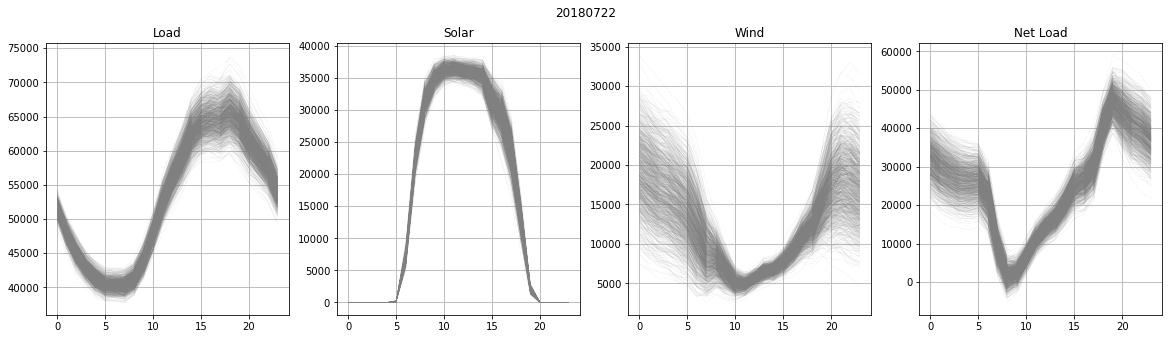

1


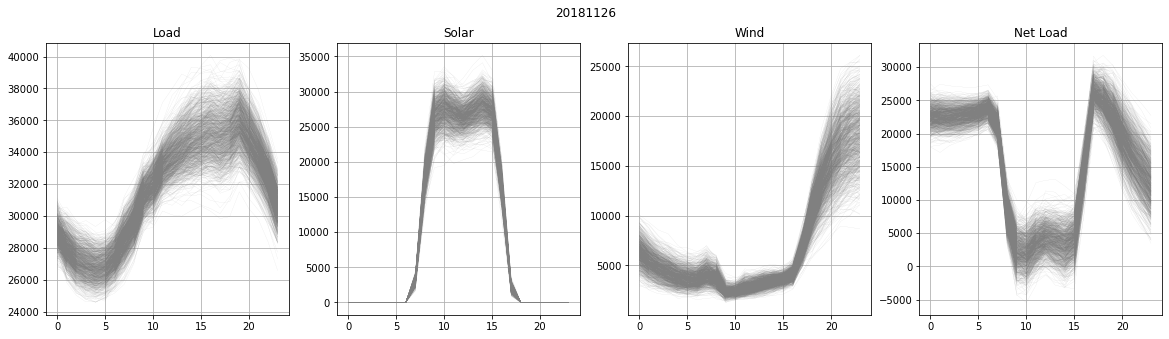

2


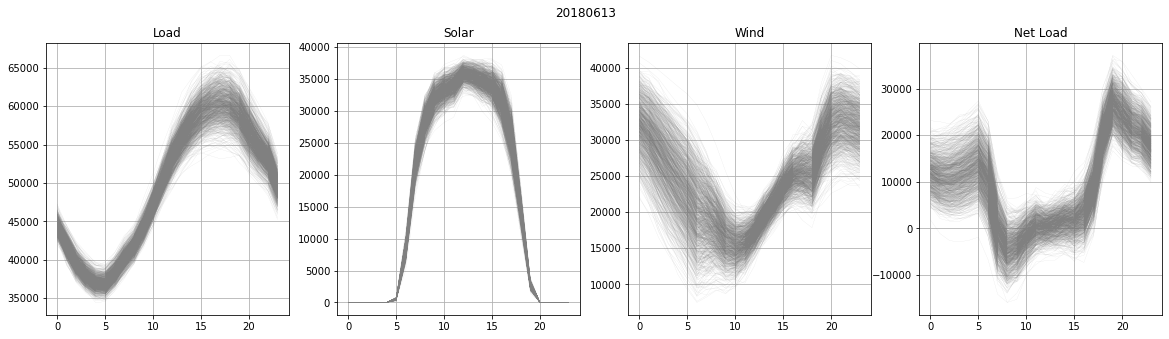

3


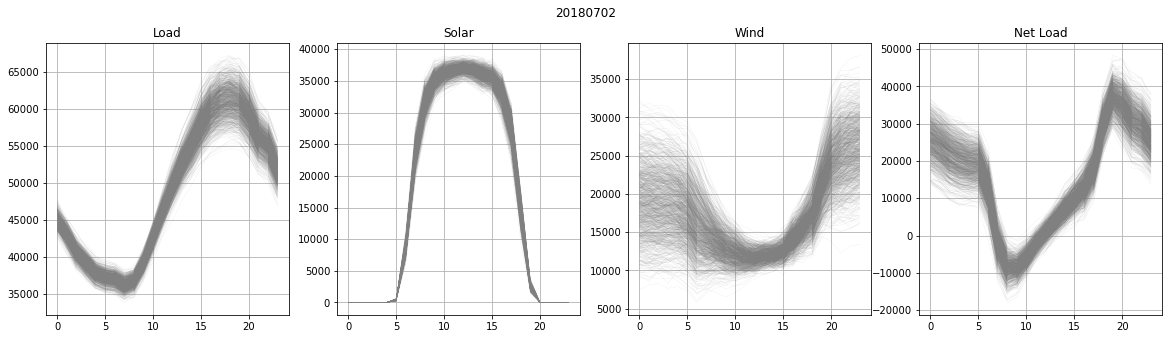

4


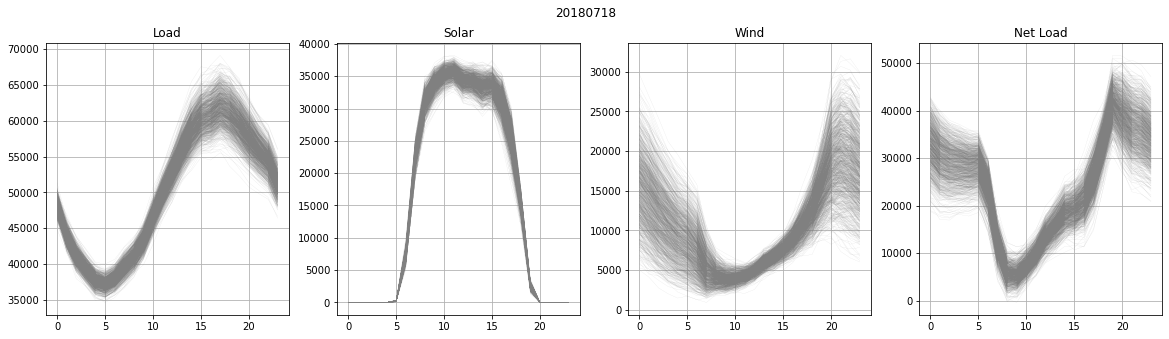

5


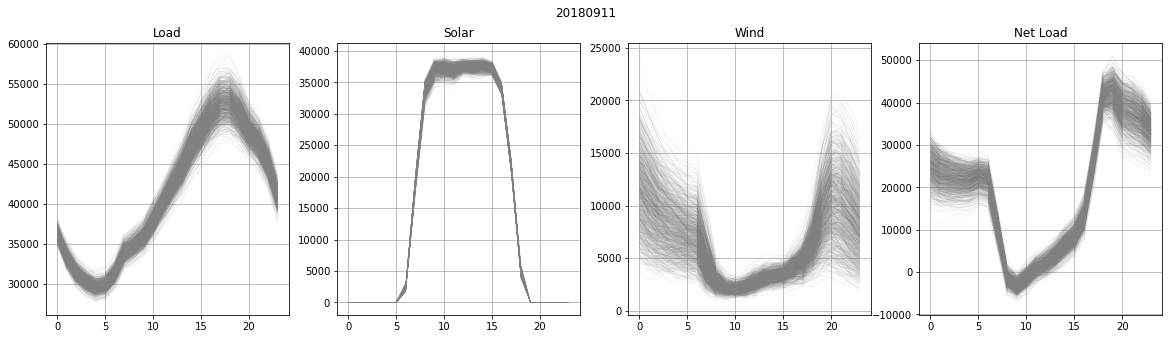

In [7]:
for i_date in range(n_ac_.shape[0]):
    print(i_date)
    
    plt.figure(figsize = (20, 5))
    plt.suptitle(files_[i_date][-8:])
    plt.subplot(141)
    plt.title("Load")
    plt.plot(L_sc_[i_date, ...], c = 'gray', linewidth = .05)
    plt.grid()

    plt.subplot(142)
    plt.title("Solar")
    plt.plot(S_sc_[i_date, ...], c = 'gray', linewidth = .05)
    plt.grid()
    
    plt.subplot(143)
    plt.title("Wind")
    plt.plot(W_sc_[i_date, ...], c = 'gray', linewidth = .05)
    plt.grid()
    
    plt.subplot(144)
    plt.title("Net Load")
    plt.plot(N_sc_[i_date, ...], c = 'gray', linewidth = .05)
    plt.grid()
    plt.show()

In [8]:
i_date = 0 # Folder contends all information of a single date

# Load Data corresponding to a simulation
Sim_ = _load_all_datasets(files_[i_date])

# All Scenarios of Load in a Date
l_ac_  = Sim_[0][0]
l_fc_  = Sim_[0][1]
L_sc_  = Sim_[0][2]
l_nam_ = Sim_[0][3]
print(l_ac_.shape, l_fc_.shape, L_sc_.shape, len(l_nam_))

# All Scenarios of Solar in a Date
s_ac_  = Sim_[1][0]
s_fc_  = Sim_[1][1]
S_sc_  = Sim_[1][2]
s_nam_ = Sim_[1][3]
print(s_ac_.shape, s_fc_.shape, S_sc_.shape, len(s_nam_))

# All Scenarios of Solar in a Date
w_ac_  = Sim_[2][0]
w_fc_  = Sim_[2][1]
W_sc_  = Sim_[2][2]
w_nam_ = Sim_[2][3]
print(w_ac_.shape, w_fc_.shape, W_sc_.shape, len(w_nam_))

(24, 8) (24, 8) (24, 1000, 8) 8
(24, 226) (24, 226) (24, 1000, 226) 226
(24, 264) (24, 264) (24, 1000, 264) 264


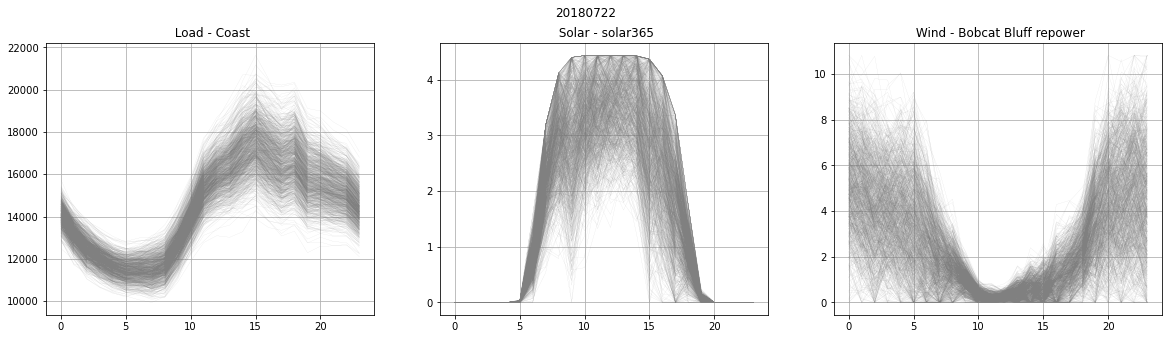

In [9]:
i_load_asset  = 1
i_solar_asset = 1 
i_wind_asset  = 1

plt.figure(figsize = (20, 5))
plt.suptitle(files_[i_date][-8:])
plt.subplot(131)
plt.title(" Load - " + l_nam_[i_load_asset])
plt.plot(L_sc_[..., i_load_asset], c = 'gray', linewidth = .05)
plt.grid()

plt.subplot(132)
plt.title(" Solar - " + s_nam_[i_solar_asset])
plt.plot(S_sc_[..., i_solar_asset], c = 'gray', linewidth = .05)
plt.grid()
plt.subplot(133)
plt.title(" Wind - " + w_nam_[i_wind_asset])
plt.plot(W_sc_[..., i_wind_asset], c = 'gray', linewidth = .05)
plt.grid()
plt.show()

In [10]:
i_asset = 1

#Y_sc_ = L_sc_[i_date, ...]
#Y_sc_ = S_sc_[i_date, ...]
Y_sc_ = W_sc_[..., i_asset]
#Y_sc_ = N_sc_[i_date, ...]
print(W_sc_.shape, Y_sc_.shape)

(24, 1000, 264) (24, 1000)


# Extremality

Given a group $\mathcal{F}$ of $N$ functional forecasting scenarios in operational day $k$ for a resource $\mathcal{R}$ defined as $\mathcal{F} = \{f^{\mathcal{R}}_{i,k} \in \mathcal{C} (\mathcal{I}), i = 1, \dots, N\}$ within the inteval $\mathcal{I} = \left[1, T\right]$ and resource class $\mathcal{R} = \{\mathcal{S}, \mathcal{W}, \mathcal{L}\}$, where $T = 24$ are the hours in an operational day.

$\textbf{Definition: }$ Extreme is a forecasting scenario $f^{\mathcal{R}}_{j,k}(t)$ which realization may pose a risk for the regulation of a power grid by an independent system operator.

$\textbf{Propierties: }$ An estreme scenario,
* over estatimes the energy generation from renewable sources $\int_{t \in \mathcal{I}} a^{\mathcal{S}, \mathcal{W}}_{k} (t) dt < \int_{t \in \mathcal{I}} f^{\mathcal{S}, \mathcal{W}}_{i,k} (t) dt$.
* under estatimes the energy demand $\int_{t \in \mathcal{I}} a^{\mathcal{L}}_{k} (t) dt > \int_{t \in \mathcal{I}} f^{\mathcal{L}}_{i,k} (t) dt$.
* have high ramp-rate in the net energy demand $\frac{df_i^{(fc)}(t)}{dt}$.

$a^{\mathcal{R}}_{k} (t)$ is the actual realization in the operational day $k$ for resource $\mathcal{R}$.

In [11]:
Y_ac_ = np.repeat(y_ac_[:, np.newaxis], N_scenarios, axis = 1)
Mu_   = np.repeat(np.mean(Y_sc_prime_, axis = 1)[:, np.newaxis], N_scenarios, axis = 1)

NameError: name 'y_ac_' is not defined

In [12]:
da_      = np.sum(np.absolute(np.diff(Y_sc_prime_, axis = 0)), axis = 0)
#da_      = np.absolute(np.sum(np.diff(Y_sc_prime_, axis = 0), axis = 0))
h_upper_ = np.sum(Y_sc_prime_ >= Y_ac_, axis = 0)
h_lower_ = np.sum(Y_sc_prime_ < Y_ac_, axis = 0)

da_ranking_      = np.argsort(da_)[::-1]
h_upper_ranking_ = np.argsort(h_upper_)[::-1]
h_lower_ranking_ = np.argsort(h_lower_)[::-1]

x_ = np.linspace(0, N_hours - 1, N_hours, dtype = int)
z_ = plt.cm.inferno(np.linspace(0, 1., N_scenarios))

plt.figure(figsize = (25, 5))
plt.suptitle(date + " - " + source + " - " + name)

plt.subplot(131)
plt.title("Total Abs. Ramp-Rates")
for idx, i in zip(da_ranking_, range(N_scenarios)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(132)
plt.title("Rank Hours Above f (ac)")
for idx, i in zip(h_upper_ranking_, range(N_scenarios)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(133)
plt.title("Rank Hours Below f (ac)")
for idx, i in zip(h_lower_ranking_, range(N_scenarios)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()
plt.show()

a_  = np.sum(Y_sc_prime_, axis = 0)
e_  = np.sum(np.absolute(Y_sc_prime_ - Y_ac_), axis = 0)
em_ = np.sum(np.absolute(Y_sc_prime_ - Mu_), axis = 0)

a_ranking_  = np.argsort(a_)[::-1]
e_ranking_  = np.argsort(e_)[::-1]
em_ranking_ = np.argsort(em_)[::-1]

plt.figure(figsize = (25, 5))
plt.suptitle(date + " - " + source + " - " + name)

plt.subplot(131)
plt.title('Area')
for idx, i in zip(a_ranking_, range(N_scenarios)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(132)
plt.title('|f (sc) - f (ac)|')
for idx, i in zip(e_ranking_, range(N_scenarios)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(133)
plt.title('|f (sc) - mu (sc)|')
for idx, i in zip(em_ranking_, range(N_scenarios)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.show()

da_      /= da_.sum()
h_lower_  = h_lower_.astype('float64')
h_lower_ /= h_lower_.sum()
a_       /= a_.sum()
e_       /= e_.sum()

huristic_ranking_ = np.argsort(a_ * e_ * da_ * h_lower_)[::-1]

plt.figure()
plt.title('Heuristic')
for idx, i in zip(huristic_ranking_, range(N_scenarios)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.show()

NameError: name 'Y_sc_prime_' is not defined

In [13]:
ranking_ = np.concatenate((da_ranking_[:, np.newaxis], 
                           h_lower_ranking_[:, np.newaxis], 
                           a_ranking_[:, np.newaxis], 
                           e_ranking_[:, np.newaxis]), axis = 1)

print(ranking_.shape)
N_extrems = 50
N_ranks = ranking_.shape[1]
idx_scenario_, counts_scenario_ = np.unique(ranking_[:N_extrems, :], return_counts = True)

idx_ = counts_scenario_ > 1.

idx_scenario_    = idx_scenario_[idx_]
counts_scenario_ = counts_scenario_[idx_]
print(idx_scenario_)
print(counts_scenario_)

N_extrems = idx_scenario_.shape[0]
print(N_extrems)
x_ = np.linspace(0, N_hours - 1, N_hours, dtype = int)

z_ = plt.cm.inferno(np.linspace(0, 1., N_ranks + 1))

plt.figure()
plt.plot(x_, Y_sc_prime_, color = 'gray')


for i in range(N_extrems):
    plt.plot(x_, Y_sc_prime_[:, idx_scenario_[i]], color = z_[counts_scenario_[i]])
plt.grid()

plt.show()

NameError: name 'da_ranking_' is not defined

(1000, 7)


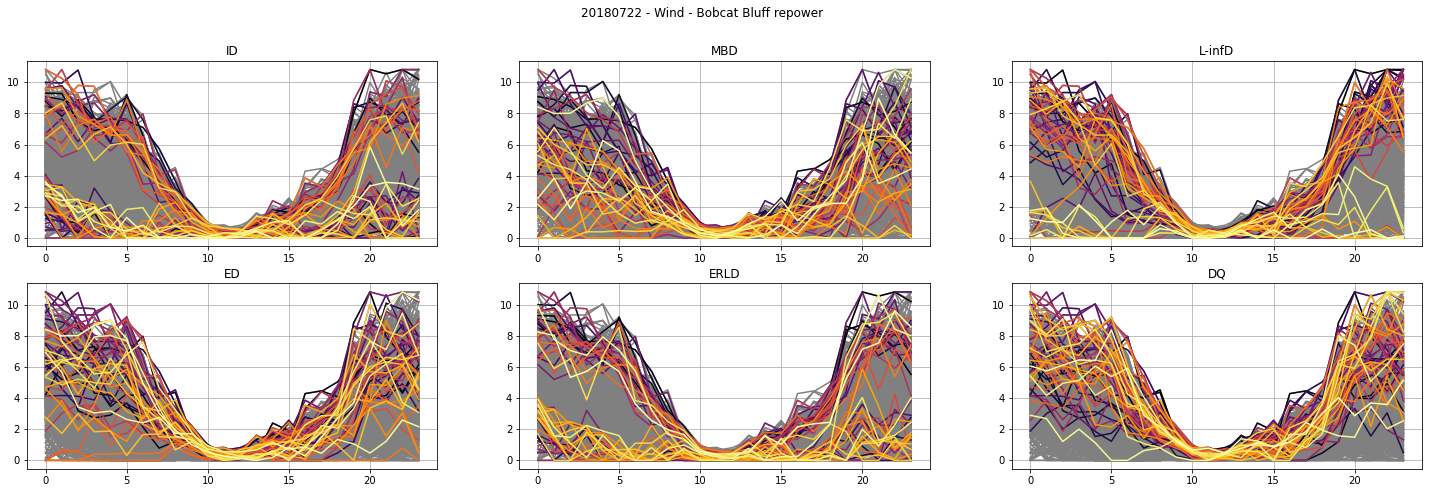

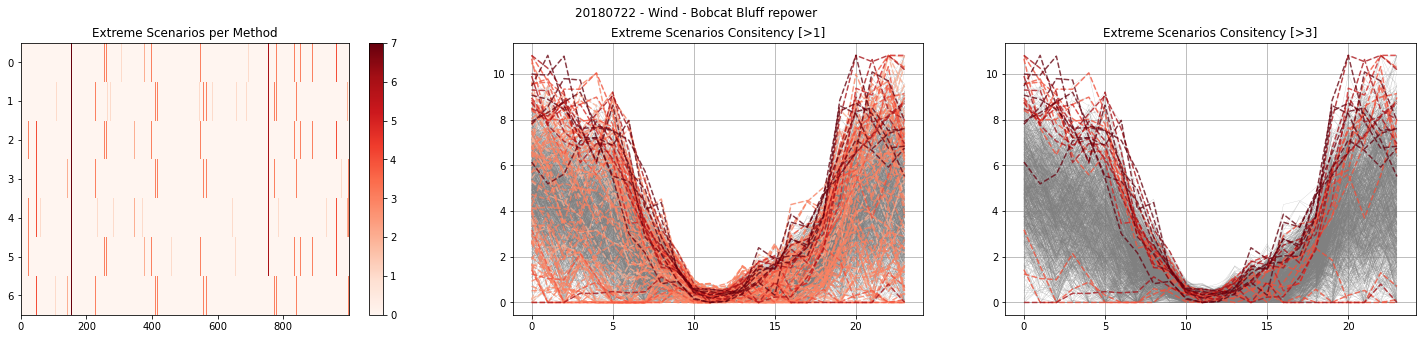

[187. 156. 196. 179. 171. 191. 174.]


In [503]:
ranking_ = np.concatenate((id_rank_[:, np.newaxis], 
                           bd_rank_[:, np.newaxis], 
                           mbd_rank_[:, np.newaxis], 
                           ed_rank_[:, np.newaxis],
                           lid_rank_[:, np.newaxis],
                           erld_rank_[:, np.newaxis],
                           dq_rank_[:, np.newaxis]), axis = 1)

print(ranking_.shape)
N_extrems = 50

x_ = np.linspace(0, N_hours - 1, N_hours, dtype = int)
z_ = plt.cm.inferno(np.linspace(0, 1., N_extrems))

plt.figure(figsize = (25, 7.5))
plt.suptitle(date + " - " + source + " - " + name)

plt.subplot(231)
plt.title('ID')
plt.plot(x_, Y_sc_prime_, color = 'gray')
for idx, i in zip(id_rank_, range(N_extrems)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(232)
plt.title('MBD')
plt.plot(x_, Y_sc_prime_, color = 'gray')
for idx, i in zip(bd_rank_, range(N_extrems)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(233)
plt.title('L-infD')
plt.plot(x_, Y_sc_prime_, color = 'gray')
for idx, i in zip(lid_rank_, range(N_extrems)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(234)
plt.title('ED')
plt.plot(x_, Y_sc_prime_, color = 'gray')
for idx, i in zip(ed_rank_, range(N_extrems)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(235)
plt.title('ERLD')
plt.plot(x_, Y_sc_prime_, color = 'gray')
for idx, i in zip(erld_rank_, range(N_extrems)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.subplot(236)
plt.title('DQ')
plt.plot(x_, Y_sc_prime_, color = 'gray')
for idx, i in zip(dq_rank_, range(N_extrems)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()

plt.show()


N_ranks = ranking_.shape[1]

C_ = np.zeros((N_scenarios, N_ranks))

idx_scenario_, counts_scenario_ = np.unique(ranking_[:N_extrems, :], return_counts = True)

for i in range(N_ranks):
    for j in range(N_extrems):
        C_[ranking_[j, i], i] = counts_scenario_[idx_scenario_ == ranking_[j, i]]
        
plt.figure(figsize = (25, 5))
plt.suptitle(date + " - " + source + " - " + name)

plt.subplot(131)
plt.title('Extreme Scenarios per Method')
plt.imshow(C_.T, aspect = 'auto', interpolation = 'None', cmap = 'Reds')
plt.colorbar()

z_ = plt.cm.Reds(np.linspace(0, 1., N_ranks + 1))

idx_cnst_        = counts_scenario_ > 1.
idx_scenario_    = idx_scenario_[idx_cnst_]
counts_scenario_ = counts_scenario_[idx_cnst_]
idx_counts_      = np.argsort(counts_scenario_)
idx_scenario_    = idx_scenario_[idx_counts_]
counts_scenario_ = counts_scenario_[idx_counts_]

plt.subplot(132)
plt.title('Extreme Scenarios Consitency [>1]')
plt.plot(x_, Y_sc_prime_, color = 'gray', linewidth = .125)
for idx, i in zip(idx_scenario_, range(idx_scenario_.shape[0])):
    plt.plot(x_, Y_sc_prime_[:, idx], '--', color = z_[counts_scenario_[i]], linewidth = 1.5, alpha = 0.75)
plt.grid()

idx_cnst_        = counts_scenario_ > 3.
idx_scenario_    = idx_scenario_[idx_cnst_]
counts_scenario_ = counts_scenario_[idx_cnst_]
idx_counts_      = np.argsort(counts_scenario_)
idx_scenario_    = idx_scenario_[idx_counts_]
counts_scenario_ = counts_scenario_[idx_counts_]

plt.subplot(133)
plt.title('Extreme Scenarios Consitency [>3]')
plt.plot(x_, Y_sc_prime_, color = 'gray', linewidth = .125)
for idx, i in zip(idx_scenario_, range(idx_scenario_.shape[0])):
    plt.plot(x_, Y_sc_prime_[:, idx], '--', color = z_[counts_scenario_[i]], linewidth = 1.5, alpha = 0.75)
plt.grid()

plt.show()

print(np.sum(C_, axis = 0))

# Functional Envelop

The functional envolop is the region defined by the less deep curves [1], such as 

$R (\mathcal{J}_k) = \left\{ \left(t, f (t) \right) : t \in D_f, \min_{x \in \mathcal{J}_k} x (t) \leq f (t) \leq \max_{x \in \mathcal{J}_k} x (t) \right\}$

where $D_f = \{1, \dots, 24\}$ and $\mathcal{J}_k$ are the set of less deep functions in asset $k$.

[1] López-Pintado, Sara, and Juan Romo. "On the concept of depth for functional data." Journal of the American statistical Association 104, no. 486 (2009): 718-734.

In [163]:
# Compute Functional Envelop
def _functional_envelop(Y_, id_rank_, alpha):
    
    # Number of Functions within Functional Interval
    N_prime = N_scenarios - int(N_scenarios*alpha)
    print(N_prime)
    Y_prime_ = Y_[:, id_rank_[-N_prime:]]

    # Compute Functional Interval Stats   
    f_upper_ = np.max(Y_prime_, axis = 1)
    f_lower_ = np.min(Y_prime_, axis = 1)
    f_mean_  = np.mean(Y_prime_, axis = 1)
    
    return f_upper_, f_lower_, f_mean_

# Lesser and Greater Depth Orderting

In [164]:
def _lesser_deepest(Y_sc_, id_rank_, N_extreme):
    
    a_mu  = np.sum(np.mean(Y_sc_, axis = 1))
    a_sc_ = np.sum(Y_sc_, axis = 0)
    
    id_rank_prime_ = []
    for i in id_rank_:

        if a_sc_[i] < a_mu:
            id_rank_prime_.append(i)
            
        if len(id_rank_prime_) == N_extreme:
            return id_rank_prime_

def _geater_deepest(Y_sc_, id_rank_, N_extreme):
    
    a_mu  = np.sum(np.mean(Y_sc_, axis = 1))
    a_sc_ = np.sum(Y_sc_, axis = 0)
    
    id_rank_prime_ = []
    for i in id_rank_:

        if a_sc_[i] > a_mu:
            id_rank_prime_.append(i)
            
        if len(id_rank_prime_) == N_extreme:
            return id_rank_prime_

$\textbf{Summary: }$ ID, BD and MDB are the results of integrating pointwise ranks. MD and ERLD are an stocastic ordering of pointwise ranks. $L_\infty$ D and DQ are based in pointwise distance. This are depth metrics for univariate functional data. Depth matrics for multivariate data exits, but are not implemented here. The most commmon is functional directional outlyingness.

# Integrated Depth (ID) 

The intrated depth is an extension of the univarite depth [1],

$ID_i = 1 - \frac{1}{T}\int_{f\in \mathcal{I}} \left| \frac{1}{2} - F_t(f(t)) \right| dt$,

where $F_t(\cdot)$ is the Empirical Fensity Function of the forecasting scenario inteval $t$.

The ID is calculated independetly estimating the EDF for each interval $t$ and then marginalizing over $t$. The less likely function is the deepest function in the set.

[2] Fraiman, Ricardo, and Graciela Muniz. "Trimmed means for functional data." Test 10, no. 2 (2001): 419-440.

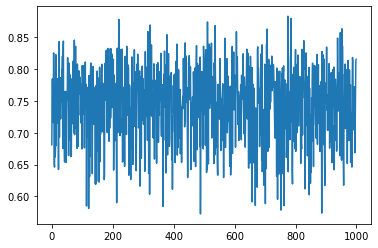

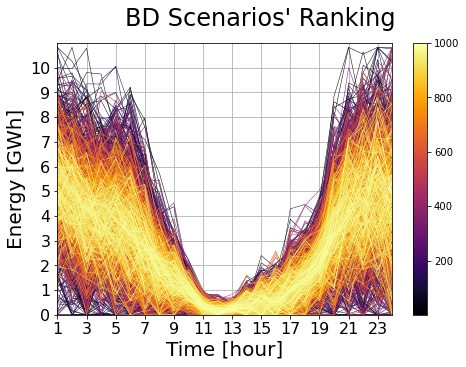

In [181]:
# Rank Functions by their Integrated Depth
def _ID_ranking(Y_):
    
    # Empirical Density Function
    def __EDF(y_, n):
        z_ = np.zeros((n,))
        for j in range(n,):
            z_[j] = (y_ < y_[j]).sum()
        return z_/n

    # Get Problem Dimensions
    N_hours, N_scenarios = Y_.shape
    
    Z_ = np.zeros((N_hours, N_scenarios))
    for i in range(N_hours):
        # d-dimension Empirical Density Function
        Z_[i, :] = __EDF(Y_[i, :], N_scenarios)

    id_       = 1. - np.sum(np.absolute(.5 - Z_), axis = 0)/N_hours
    id_rank_  = np.argsort(id_)
    
    return id_, id_rank_

id_, id_rank_ = _ID_ranking(Y_sc_)

plt.figure()
plt.plot(id_)
plt.show()

title = r"BD Scenarios' Ranking" 
name  = r"bd.pdf"
path  = r"/Users/Guille/Desktop/extreme_scenarios/images/depth/"

def _plot(Y_, rank_, title, name, path, save = False):
    
    N_hours, N_scenarios = Y_.shape


    x_ = np.linspace(0, N_hours - 1, N_hours, dtype = int)
    z_ = plt.cm.inferno(np.linspace(0, 1., N_scenarios))

    x_prime_ = x_ + 1


    plt.figure(figsize = (7.5, 5))
    plt.suptitle(title, fontsize = 24)
    for idx, i in zip(rank_, range(N_scenarios)):
        plt.plot(x_, Y_[:, idx], color = z_[i, :], linewidth = .5)

    plt.ylabel(r'Energy [GWh]', fontsize = 20)
    plt.xlabel(r'Time [hour]', fontsize = 20)

    plt.ylim(0, np.around(Y_.max()/10.)*10. + 1)
    plt.yticks(np.linspace(0, np.around(Y_.max()/10.)*10., 11), fontsize = 16)
    plt.xticks(x_[::2], x_prime_[::2], fontsize = 16)
    plt.xlim([0, 23])
    plt.grid()
    plt.colorbar(plt.cm.ScalarMappable(cmap = 'inferno', norm = plt.Normalize(vmin = 1, vmax = 1000)))
    if save: plt.savefig(path + name)
    else:    plt.show()
        
_plot(Y_sc_, id_rank_, title, name, path, save = False)

# Band Depth (BD)


The proportion of bands is defined as the number of pair of functional observaction containing a third function observation. This is depth measure is BD when $J = 2$. The BD is computationlly expensive [3] but it exists a fast implementation [4], 

$BD_i = \frac{ \left[ \min R_i (t) - 1 \right] \left[ N - \max R_i (t) \right] + N - 1}{N (N + 1)}$,

where $R_i(t)$ is the rank of $f_i(t)$.

The BD estimate the depth quantifing how many times a given funtion is within any other pair of functions in the set.

[3] López-Pintado, Sara, and Juan Romo. "Depth-based classification for functional data." DIMACS Series in Discrete Mathematics and Theoretical Computer Science 72 (2006): 103.

[4] Sun, Ying, Marc G. Genton, and Douglas W. Nychka. "Exact fast computation of band depth for large functional datasets: How quickly can one million curves be ranked?." Stat 1, no. 1 (2012): 68-74.

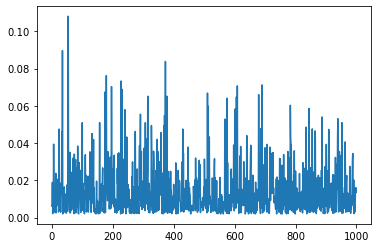

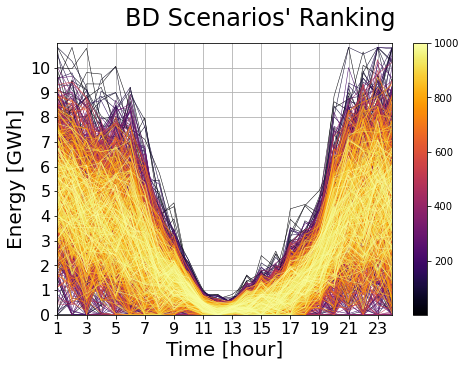

In [183]:
def _BD(Y_):    
    # band_depth <- function(dt){
    #   if (is.data.frame(dt)) {
    #     dt <- as.matrix(dt)
    #   }

    #   if (!is.array(dt) || !is.numeric(dt))
    #     stop("Argument \"dt\" must be a nonempty numeric matrix or dataframe.")

    #   if (any(!is.finite(dt))) {
    #     stop("Missing or infinite values are not allowed in argument \"dt\"")
    #   }

    #   n <- dim(dt)[1]
    #   rank_matrix <- apply(dt, 2, rank)
    #   down <- apply(rank_matrix, 1, min) - 1
    #   up <- n-apply(rank_matrix, 1, max)
    #   unname((up*down+n-1)/choose(n,2))
    # }

    N_hours, N_scenarios = Y_.shape

    rank_ = rankdata(Y_, method = 'average', axis = 1)
    down_ = np.min(rank_, axis = 0) - 1. 
    up_   = N_scenarios - np.max(rank_, axis = 0)

    bd_      = ((up_ * down_) + N_scenarios - 1)/binom(N_scenarios, 2)
    bd_rank_ = np.argsort(bd_)
    
    return bd_, bd_rank_

bd_, bd_rank_ = _BD(Y_sc_)

plt.figure()
plt.plot(bd_)
plt.show()

title = r"BD Scenarios' Ranking"
_plot(Y_sc_, bd_rank_, title, name, path, save = False)

# Modified Band Depth (MBD)

MBD is similar to BD but more flexible beucase MDB measures the proportion of the time that a functional observation is within the band instead of whether it is within or not [3]. Therefore, it potentilly avoids ties [5]. It is computationally expensive as well, but it exist a fast implementation when $J = 2$ [4],

$MBD_i = \frac{1}{N (N + 1)} \int_{t \in \mathcal{I}} \frac{\left[ R_i(t) - 1 \right] \left[N - R_i (t) \right]}{N - T - 1}$.

[5] Wai, Wenlin, Tomáš Mrkvička, Ying Sun, and Marc G. Genton. "Functional outlier detection and taxonomy by sequential transformations." Computational Statistics & Data Analysis 149 (2020): 106960.

7.814919595059379


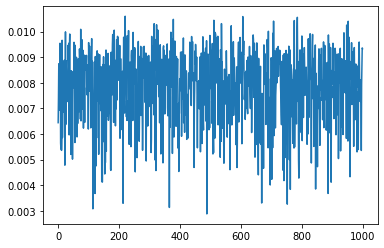

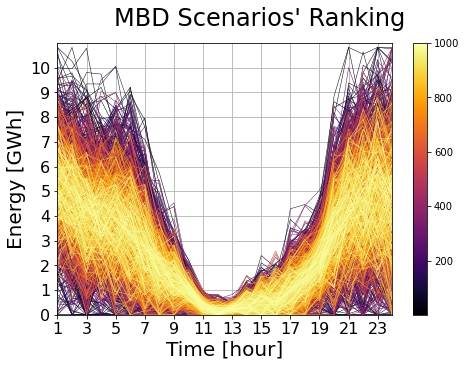

In [185]:
def _MBD(Y_):
    
    # modified_band_depth <- function(dt){
    #   if (is.data.frame(dt)) {
    #     dt <- as.matrix(dt)
    #   }

    #   if (any(!is.finite(dt))) {
    #     stop("Missing or infinite values are not allowed in argument \"dt\"")
    #   }

    #   if (!is.array(dt) || !is.numeric(dt))
    #     stop("Argument \"dt\" must be a non empty numeric matrix or dataframe.")
    #   dm <- dim(dt)
    #   p <- dm[2]
    #   n <- dm[1]
    #   if(n < 2) stop("Number of row of argument 'dt' must be greater than 1")
    #   rnkmat <- apply(dt,2,rank) # switches matrix to max(p,n) by min(p,n)
    #   down <- rnkmat-1
    #   up <- n-rnkmat
    #   unname((rowSums(up*down)/p+n-1)/choose(n,2))
    # }
    
    N_hours, N_scenarios = Y_.shape

    rank_ = rankdata(Y_, method = 'average', axis = 1)
    down_ = rank_ - 1. 
    up_   = N_scenarios - rank_

    mbd_      = (np.sum(down_ * up_, axis = 0)/(N_scenarios + N_hours - 1))/binom(N_scenarios, 2)
    mbd_rank_ = np.argsort(mbd_)

    return mbd_, mbd_rank_

mbd_, mbd_rank_ = _MBD(Y_sc_)

plt.figure()
plt.plot(mbd_)
plt.show()

title = r"MBD Scenarios' Ranking"
_plot(Y_sc_, mbd_rank_, title, name, path, save = False)

# Extremal Depth (ED)

It is a depth matric based on the pointwise depth of ascenario $f_i(t)$, 

$d_i (t) = 1 - \frac{\left| 2R_i(t) - N - 1\right|}{N})$,
 
which depth cumulative density functions is,

$\phi_i = \frac{1}{T} \int_{t in \mathcal{I}} \mathbb{I} \left( d_i (t) \leq r \right) dt$

for each possible mass depth $r \in \{1, \dots, T \}$. The functional observations $f_i(t)$ are ranked by $\phi_i$. When ties exits,

$I_i = \arg \left[ \phi = \text{sort} \left[ \phi \right]_i \right]$,

the $\phi_j (t)$ are sorted by mass depth $r_j$. The ED of a function observation is,

$ED_i = I_{i} \left[ \arg \text{sort} \left[ r_{I_i} \right] \right]$.

Notice computing notation abuse for the sake of simplification.

[8] Narisetty, Naveen N., and Vijayan N. Nair. "Extremal depth for functional data and applications." Journal of the American Statistical Association 111, no. 516 (2016): 1705-1714.

(1000, 24)
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.009 0.011 0.012 0.013 0.014
 0.015 0.016 0.017 0.019 0.02  0.021 0.022 0.023 0.025 0.027 0.028 0.029
 0.03  0.031 0.033 0.035 0.037 0.039 0.041 0.043 0.045 0.047 0.049 0.051
 0.053 0.055 0.057 0.059 0.061 0.062 0.063 0.065 0.067 0.069 0.071 0.073
 0.075 0.077 0.079 0.081 0.083 0.085 0.087 0.089 0.091 0.093 0.095 0.096
 0.097 0.099 0.101 0.103 0.105 0.107 0.109 0.111 0.113 0.115 0.117 0.119
 0.121 0.123 0.125 0.127 0.128 0.129 0.131 0.133 0.135 0.139 0.141 0.143
 0.145 0.147 0.149 0.151 0.153 0.155 0.157 0.159 0.161 0.163 0.165 0.167
 0.169 0.175 0.177 0.179 0.181 0.182 0.183 0.185 0.187 0.191 0.192 0.195
 0.197 0.201 0.203 0.207 0.211 0.213 0.215 0.219 0.223 0.225 0.229 0.231
 0.233 0.241 0.243 0.249 0.251 0.265 0.267 0.273 0.275 0.279 0.283 0.287
 0.291 0.293 0.295 0.305 0.307 0.315 0.323 0.325 0.329 0.346]


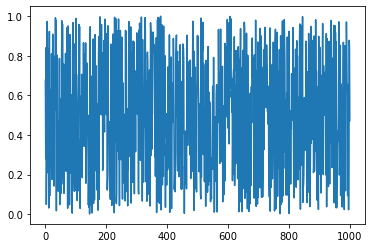

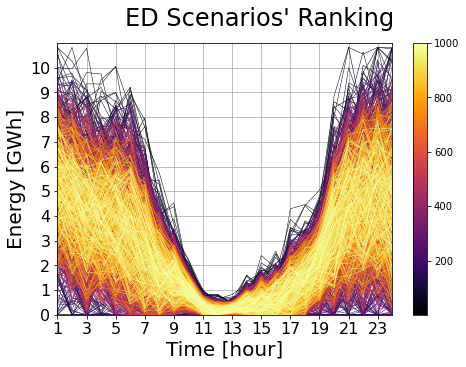

In [191]:
def _ED(Y_):
    # extremal_depth <- function(dts){
    #   if(is.data.frame(dts)){
    #     dts <- as.matrix(dts)
    #   }

    #   if(!is.array(dts) || !is.numeric(dts))
    #     stop("Argument \"dts\" must be a numeric matrix or dataframe.")

    #   if (any(!is.finite(dts))){
    #     stop("Missing or infinite values are not allowed in argument \"data\"")
    #   }
    #   if(nrow(dts) < 3) stop("The number of curves must be greater than 2")

    #   ddim <- dim(dts)
    #   n <- ddim[1]
    #   p <- ddim[2]
    #   pwdepth <- pwise_depth(dt = dts, n = n) # matrix of n by p
    #   pmfs <- apply(pwdepth, 1, function(x){
    #     pmf <- table(x)/p
    #     return(c(as.numeric(names(pmf[1])), # depth level and mass
    #              pmf[1]))
    #   })

    #   depth_levels <- pmfs[1,]
    #   masses <- pmfs[2, ]
    #   # order functions according to depth_levels and mass
    #   ordered_functions <- sapply(sort(unique(depth_levels),
    #                                    method = "quick"),
    #                               function(x){
    #     fns_depth_level <- which(depth_levels == x)
    #     if(length(fns_depth_level) > 1){
    #       fns_depth_level[order(masses[fns_depth_level], decreasing = T)]
    #     }else{
    #       fns_depth_level
    #     }
    #   })
    #   ordered_functions <- unlist(ordered_functions)
    #   depth_values <- ((1:n)/n)[order(ordered_functions)]
    # }

    # pwise_depth <- function(dt, n) {
    #   pdepth <- apply(dt, 2, function(i){
    #     (1 - abs(2*rank(i) - n -1)/n) # for rank r, d = ((r - 1) + (n - r))/n
    #   })
    #   return(pdepth)
    # }
    def __piecewise_depth(Y_, N_scenarios):
        print(Y_.shape)
        depth_ = np.zeros(Y_.shape)
        for i in range(Y_.shape[1]):
            y_ = Y_[:, i]
            rank_ = rankdata(y_, method = 'average')
            depth_[:, i] = 1. - np.absolute(2.*rank_ - N_scenarios - 1)/N_scenarios
        return depth_

    N_hours, N_scenarios = Y_.shape

    depth_ = __piecewise_depth(Y_.T, N_scenarios)
    
    # Compute Probability Mass Function
    pmfs_  = np.zeros((2, N_scenarios))
    for j in range(N_scenarios):
        pmf_, freq_ = np.unique(depth_[j, :], return_counts = True)
        freq_  = freq_.astype('float64')
        freq_ /= N_hours

        pmfs_[0, j] = pmf_[0]
        pmfs_[1, j] = freq_[0]


    # Sort Depth Levels
    sort_depth_levels_ = np.sort(np.unique(pmfs_[0, :]))
    print(sort_depth_levels_)
    sort_detph_ = []
    for depth_level in sort_depth_levels_:

        idx_ = np.where(pmfs_[0, :] == depth_level)[0]

        if idx_.shape[0] > 1:
            sort_masses = np.argsort(pmfs_[1, :][idx_])[::-1]
            sort_detph_.append(idx_[sort_masses])
        else:
            sort_detph_.append(idx_)
            
    # Construct Ranking Vectors
    sort_depth_prime_ = []
    for sort_depth in sort_detph_:
        for sort_depth_prime in sort_depth:
            sort_depth_prime_.append(sort_depth_prime)
    sort_depth_prime_prime_ = np.array(sort_depth_prime_)   

    x_       = np.linspace(1, N_scenarios, N_scenarios)/N_scenarios
    ed_      = x_[np.argsort(sort_depth_prime_prime_)]
    ed_rank_ = np.argsort(ed_)
    return ed_, ed_rank_

ed_, ed_rank_ = _ED(Y_sc_)

plt.figure()
plt.plot(ed_)
plt.show()

title = r"ED Scenarios' Ranking"
_plot(Y_sc_, ed_rank_, title, name, path, save = False)

# $L_{\infty}$ Depth ($L_{\infty}$D)

The $L_{\infty}$D measures the average distance between each pair of functional observations. The distance metric is defined the Chebyshev distance $\| \cdot \|_{\infty}$ [6],

$L_{\infty}D_i = \frac{1}{1 + \frac{1}{N}\sum_{\ell = 1}^N \| f_\ell(t) - f_i(t) \|_\infty}$.

This distance-based depth notion is generalizable to any distance metric [7].

[6] Long, J.P., Huang, J.Z., 2015. A study of functional depths. ArXiv preprint arXiv:1506.01332.

[7] Zuo, Yijun, and Robert Serfling. "General notions of statistical depth function." Annals of statistics (2000): 461-482.

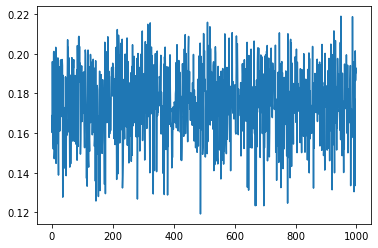

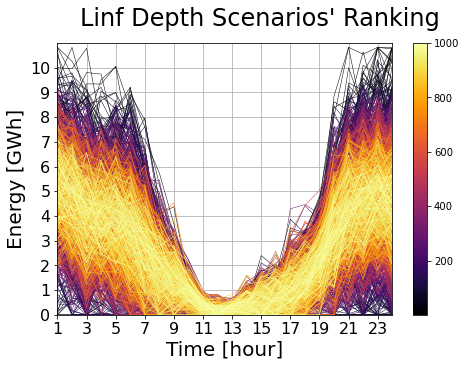

In [187]:
from scipy.spatial.distance import chebyshev

def _LinfD(Y_): 
    # linfinity_depth <- function(dt){
    #   if (is.data.frame(dt)) {
    #     dt <- as.matrix(dt)
    #   }

    #   if (!is.array(dt) || !is.numeric(dt))
    #     stop("Argument \"dt\" must be a numeric matrix or dataframe.")

    #   if (any(!is.finite(dt))) {
    #     stop("Missing or infinite values are not allowed in argument \"dt\"")
    #   }

    #   # distance very large if n is big. to cpp?
    #   distances <- as.matrix(dist(dt, method = "maximum", diag = T, upper = T))
    #   unname(1/(1+colMeans(distances)))
    # }
    
    N_hours, N_scenarios = Y_.shape
    
    D_ = np.zeros((N_scenarios, N_scenarios))
    for i in range(N_scenarios):
        y_ = Y_[:, i]
        for j in range(N_scenarios):
            y_prime_ = Y_[:, j]
        
            D_[i, j] = chebyshev(y_, y_prime_)
    
    lid_      = 1./(1. + np.mean(D_, axis = 1))
    lid_rank_ = np.argsort(lid_)
    return lid_, lid_rank_

lid_, lid_rank_ = _LinfD(Y_sc_)

plt.figure()
plt.plot(lid_)
plt.show()

title = r"Linf Depth Scenarios' Ranking"
_plot(Y_sc_, lid_rank_, title, name, path, save = False)

# Extreme Rank Length Depth (ERLD)

After ranking all functional observations, ERLD allows for dicriminating when small values, large values or both small and large values are considered extrame [9].
           
$ERLD_i = \frac{1}{N} \mathbb{O} \left( R^\prime_i (t), R^\prime_j (t) \right)$,

where $R^\prime_i (t)$ is defined as,

$R^\prime_i (t) = \begin{cases} 
                      R_i (t) & \text{small value extrame} \\
                      N + 1 - R_i(t) & \text{larg value extrame} \\
                      \min \left[R_i (t), N + 1 - R_i(t) \right] & \text{both small and large values are extreme},
                  \end{cases}$

and $\mathbb{O} ( \cdot )$ is an stochastic ordering function, 

$d_{i} \triangleq \mathbb{O} \left( R^\prime_i (t), R^\prime_j (t) \right) =  \begin{cases} 
                                                                 d_j (t) = d_j + 1 & R_i (t) > R_i (t) \\
                                                                 d_j (t) = d_j + 1 & R_i (t) < R_i (t) \\
                                                                 d_i (t) = d_i + \frac{1}{2},
                                                                 d_j (t) = d_j + \frac{1}{2} & R_i (t) = R_i (t) 
                                                              \end{cases}$

[9] Mrkvička, Tomáš, Mari Myllymäki, and Ute Hahn. "Multiple Monte Carlo testing, with applications in spatial point processes." Statistics and Computing 27, no. 5 (2017): 1239-1255.

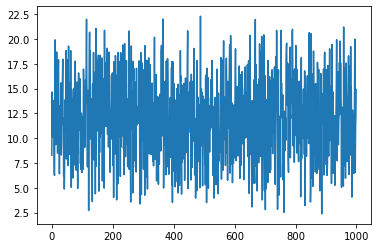

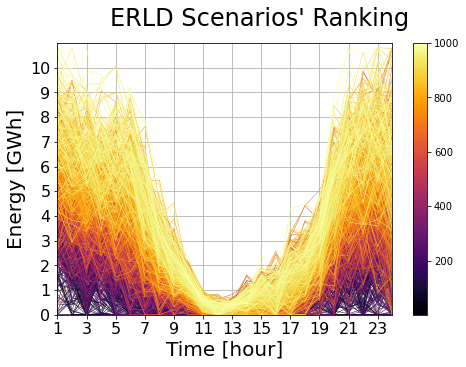

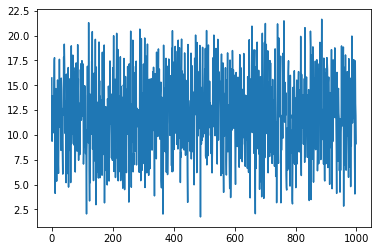

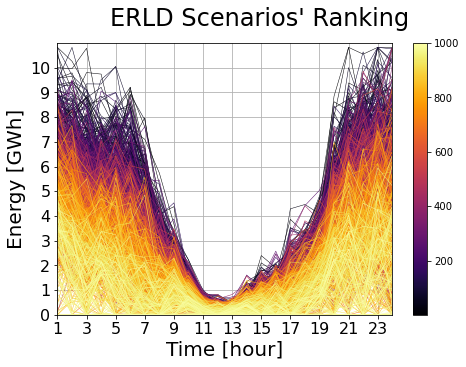

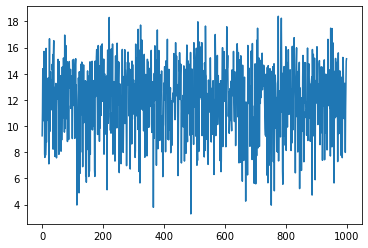

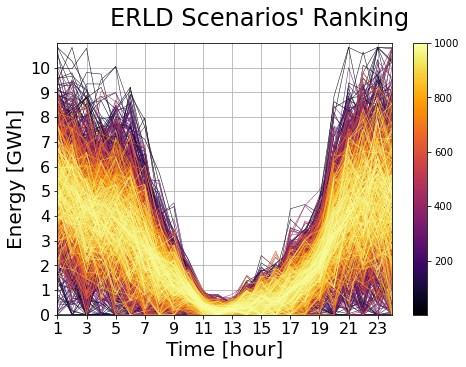

In [188]:
# Extreme Rank Length Depth
def _ERLD(Y_, method):
    # left-tail stochastic ordering of the depth distributions
    def _stochastic_ordering(R_, depth_, i, j):
        N_hours, N_scenarios = R_.shape
        for k in range(N_hours):
            # j-th smaller than i-th
            if R_[k, i] > R_[k, j]:
                depth_[i] += 1
            # i-th smaller than j-th
            if R_[k, i] < R_[k, j]:
                depth_[j] += 1
            # Tied   
            if R_[k, i] == R_[k, j]:
                depth_[i] += .5
                depth_[j] += .5
        return depth_

    N_hours, N_scenarios = Y_.shape

    # pointwise ranks for each method 
    R_prime_ = rankdata(Y_, axis = 1, method = 'average')
    if method == 'small one-sided test':
        R_ = R_prime_.copy()
    if method == 'large one-sided test':
        R_ = N_scenarios + 1 - R_prime_
    if method == 'two-sided test':
        r_prime_ = R_prime_.flatten()[:, np.newaxis]
        r_       = np.min(np.concatenate((r_prime_, N_scenarios + 1 - r_prime_), axis = 1), axis = 1)
        R_       = r_.reshape(N_hours, N_scenarios)
    
    # The ERLD of the rank
    depth_ = np.zeros((N_scenarios,))

    for i in range(N_scenarios):
        for j in range(i, N_scenarios):
            depth_ = _stochastic_ordering(R_, depth_, i, j)
        
    erld_      = depth_/N_scenarios
    erld_rank_ = np.argsort(erld_)
    return erld_, erld_rank_

erld_, erld_rank_ = _ERLD(Y_sc_, method = 'small one-sided test')

plt.figure()
plt.plot(erld_)
plt.show()

title = r"ERLD Scenarios' Ranking"
_plot(Y_sc_, erld_rank_, title, name, path, save = False)

erld_, erld_rank_ = _ERLD(Y_sc_, method = 'large one-sided test')

plt.figure()
plt.plot(erld_)
plt.show()

title = r"ERLD Scenarios' Ranking"
_plot(Y_sc_, erld_rank_, title, name, path, save = False)

erld_, erld_rank_ = _ERLD(Y_sc_, method = 'two-sided test')


plt.figure()
plt.plot(erld_)
plt.show()

title = r"ERLD Scenarios' Ranking"
_plot(Y_sc_, erld_rank_, title, name, path, save = False)

# Directional Quantile (DQ)

ERLD can potentially have ties [5]. The DQ is an approximation of ERLD [9], when small and large value is extrame, without this problem,

$DQ_i = \max \left( \mathbb{I} \left( f_i(t) \geq \mu (t) \right) \frac{f_i(t) - \mu (t)}{\left| Q_{97.5}(t) - \mu (t) \right|} + \mathbb{I} \left( f_i(t) < \mu(t) \right)  \frac{f_i(t) - \mu (t) }{\left| Q_{2.5} (t) - \mu (t) \right|} \right)$, 

where $Q_{97.5} (t)$ and $Q_{2.5} (t)$ are the $5\%$ quantiles of $f_i(t)$.

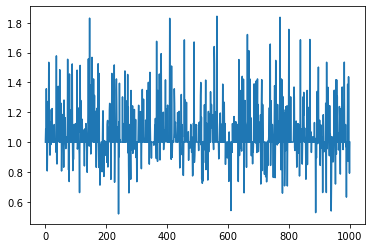

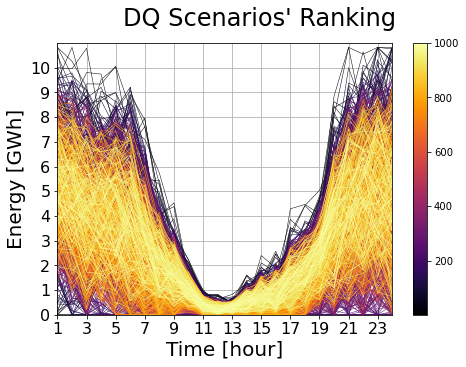

In [190]:
# Directional quantile of the two-sided ERLD
def _DQ(Y_, method, q_ = [.025, .975]):
    
    N_hours, N_scenarios = Y_.shape
    
    # Detrend Functional Data
    M_       = np.repeat(np.mean(Y_, axis = 1)[:, np.newaxis], N_scenarios, axis = 1)
    Y_prime_ = Y_ - M_
    
    # Compute Quantile Statistics
    Q_       = np.quantile(Y_prime_, q_, axis = 1)
    Q_lower_ = np.repeat(Q_[0, :][:, np.newaxis], N_scenarios, axis = 1)
    Q_upper_ = np.repeat(Q_[1, :][:, np.newaxis], N_scenarios, axis = 1)

    #  DQ is the largest pointwise outlyingness
    DQ_              = np.zeros((N_hours, N_scenarios))
    idx_lower_       = Y_prime_ < 0.
    DQ_[idx_lower_]  = Y_prime_[idx_lower_]/np.absolute(Q_lower_[idx_lower_])
    DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])

    if method == 'small one-sided test':
#         dq_      = np.min(DQ_, axis = 0)
#         dq_rank_ = np.argsort(dq_)
        dq_      = np.max(DQ_, axis = 0)
        dq_rank_ = np.argsort(dq_)
    if method == 'large one-sided test':
        dq_      = np.max(DQ_, axis = 0)
        dq_rank_ = np.argsort(dq_)[::-1]
    if method == 'two-sided test':
        dq_      = np.max(np.absolute(DQ_), axis = 0)
        dq_rank_ = np.argsort(dq_)[::-1]
    return dq_, dq_rank_

dq_, dq_rank_ = _DQ(Y_sc_, q_ = [.025, .975], method = 'two-sided test')


plt.figure()
plt.plot(dq_)
plt.show()

title = r"DQ Scenarios' Ranking"
_plot(Y_sc_, dq_rank_, title, name, path, save = False)

# Extremal Depth (ED)

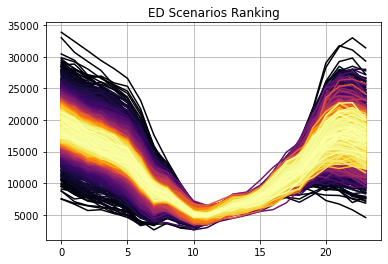

In [217]:
# Rank Functions by their Extramal Depth
def _ED_ranking(Y_):
    
    # Pointwise depth of each function in the set Y
    def __pointwise_depth(Y_, N_hours, N_scenarios):
        
        # Initialize Pointwise Depth Variable
        D_ = np.zeros((N_hours, N_scenarios))

        for i in range(N_scenarios):
            # Get the i-th function in the set
            g_ = Y_[:, i]
            # Initialize g (i-th fucntion) Pointwise Depth Variable
            d_g_ = np.zeros((N_hours, N_scenarios))
            for j in range(N_scenarios):
                # Get the j-th function in the set
                f_ = Y_[:, j]  
                # Compare Depth of g (i-th function) against f (j-th function)
                d_g_[:, j] = 1.*(f_ < g_) - 1.*(f_ > g_)
            # Compute pointwise depth of g (i-th function)
            D_[:, i] = 1. - np.absolute(np.sum(d_g_, axis = 1))/N_scenarios
        
        return D_
    
    # Rank Functions by d-dimensional Comulative Density Function
    def __rank(D_, N_hours, N_scenarios):
    
        # d-CDF
        def ___CDF(d_, i, N_hours):
            r = (i + 1.)/N_hours
            return np.cumsum(d_ <= r, axis = 0)/N_hours
        
        # Find which function is greater
        def ___ordering(d_g_, d_h_, N_hours):

            # Order d-CDF incresing the functional domain
            for i in range(N_hours):
                # Compute d-CDF of g (i-th function)
                phi_d_g_ = ___CDF(d_g_, i, N_hours)
                # Compute d-CDF of h (j-th function)
                phi_d_h_ = ___CDF(d_h_, i, N_hours)

                # Which d-CDF interval explain more probability?
                # g;
                if phi_d_g_[i] > phi_d_h_[i]:
                    return 0.
                # or h:
                if phi_d_g_[i] < phi_d_h_[i]:
                    return 1.
            return 1.


        # Rank Functions by extremal depth
        ed_rank_ = np.zeros((N_scenarios,))

        for i in range(N_scenarios):
            for j in range(N_scenarios):
                # Compare d-CDF of g (i-th function) against f (j-th function)
                ed_rank_[i] += ___ordering(D_[:, i], D_[:, j], N_hours)

        return ed_rank_ / N_scenarios
        
    # Get Problem Dimensions
    N_hours, N_scenarios = Y_.shape
    
    # Compute the pointwise detph
    D_ = __pointwise_depth(Y_, N_hours, N_scenarios)
    
    # Extrem Depth Ranking
    ed_      = __rank(D_, N_hours, N_scenarios)
    ed_rank_ = np.argsort(ed_)    
    return ed_, ed_rank_ 

# Extramal Depth Functional intervals
def _ED_functional_intervals(Y_, ed_, alpha):
    # Number of Functions within Functional Interval
    idx_ed_  = ed_ > alpha
    Y_prime_ = Y_[:, idx_ed_]
    print(idx_ed_.sum())
    
    # Compute Functional Interval Stats   
    f_upper_ = np.max(Y_prime_, axis = 1)
    f_lower_ = np.min(Y_prime_, axis = 1)
    f_mean_  = np.mean(Y_prime_, axis = 1)
    
    return f_upper_, f_lower_, f_mean_
    
ed_, ed_rank_ = _ED_ranking(Y_sc_)

plt.figure()
plt.title('ED Scenarios Ranking')
for idx, i in zip(ed_rank_, range(N_scenarios)):
    plt.plot(x_, Y_sc_[:, idx], color = z_[i])
plt.grid()
plt.show()

In [ ]:
N_extreme = 15

c_ = np.linspace(0, N_extreme - 1, N_extreme)/N_extreme
x_ = np.linspace(0, N_hours - 1, N_hours, dtype = int)
z_ = plt.cm.inferno(np.linspace(0, 1., N_scenarios))
w_ = plt.cm.gist_rainbow(c_)

norm = mpl.colors.Normalize(vmin = c_.min()*N_extreme, vmax = c_.max()*N_extreme)
cmap = mpl.cm.ScalarMappable(norm = norm, cmap = mpl.cm.gist_rainbow)
cmap.set_array([])

# Rank Functions by ID

plt.figure(figsize = (30, 5))

id_, id_rank_ = _ID_ranking(L_sc_[0, ...])
id_extreme_   = _greater_extreme(L_sc_[0, ...], id_rank_, N_extreme)

plt.subplot(141)
plt.title('ID Less Deep Scenarios')
plt.plot(x_, L_sc_[0, ...], color = 'gray', linewidth = .2, zorder = 1)

for i, j in zip(id_extreme_, range(N_extreme)):
    plt.plot(x_, L_sc_[0, :, i], '-', color = w_[-j -1], linewidth = 3.5, zorder = 5, alpha = 1.)
        
#plt.colorbar(cmap, ticks = c_*N_extreme)      
plt.grid()

id_, id_rank_ = _ID_ranking(S_sc_[0, ...])
id_extreme_   = _lesser_extreme(S_sc_[0, ...], id_rank_, N_extreme)

plt.subplot(142)
plt.title('ID Less Deep Scenarios')
plt.plot(x_, S_sc_[0, ...], color = 'gray', linewidth = .2, zorder = 1)

for i, j in zip(id_extreme_, range(N_extreme)):
    plt.plot(x_,S_sc_[0, :, i], '-', color = w_[-j -1], linewidth = 3.5, zorder = 5, alpha = 1.)
        
#plt.colorbar(cmap, ticks = c_*N_extreme)      
plt.grid()

id_, id_rank_ = _ID_ranking(W_sc_[0, ...])
id_extreme_   = _lesser_extreme(W_sc_[0, ...], id_rank_, N_extreme)

plt.subplot(143)
plt.title('ID Less Deep Scenarios')
plt.plot(x_, W_sc_[0, ...], color = 'gray', linewidth = .2, zorder = 1)

for i, j in zip(id_extreme_, range(N_extreme)):
    plt.plot(x_, W_sc_[0, :, i], '-', color = w_[-j -1], linewidth = 3.5, zorder = 5, alpha = 1.)
        
#plt.colorbar(cmap, ticks = c_*N_extreme)      
plt.grid()

id_, id_rank_ = _ID_ranking(N_sc_[0, ...])
id_extreme_   = _greater_extreme(N_sc_[0, ...], id_rank_, N_extreme)

plt.subplot(144)
plt.title('ID Less Deep Scenarios')
plt.plot(x_, N_sc_[0, ...], color = 'gray', linewidth = .2, zorder = 1)

for i, j in zip(id_extreme_, range(N_extreme)):
    plt.plot(x_, N_sc_[0, :, i], '-', color = w_[-j -1], linewidth = 3.5, zorder = 5, alpha = 1.)
        
#plt.colorbar(cmap, ticks = c_*N_extreme)      
plt.grid()

plt.show()

plt.figure(figsize = (25, 10))

plt.subplot(121)
plt.title("ID Scenarios' Ranking")
for idx, i in zip(id_rank_, range(N_scenarios)):
    plt.plot(x_, Y_sc_[:, idx], color = z_[i])
plt.grid()

plt.subplot(122)
plt.title('ID Less Deep Scenarios')
plt.plot(x_, Y_sc_, color = 'gray', linewidth = .2, zorder = 1)
#plt.fill_between(x_, f_lower_50_, f_upper_50_, color = 'k', label = 'fci', alpha = .35, zorder = 2)
#plt.plot(x_, f_upper_50_, '--', color = 'k', linewidth = .5, label = 'fucb', zorder = 2)
#plt.plot(x_, f_lower_50_, '--', color = 'k', linewidth = .5, label = 'flcb',zorder = 2)
#plt.plot(x_, f_mean_50_, '-', color = 'k', marker = 'x', markersize = 10, label = 'fmu', linewidth = 1., zorder = 4)
#plt.plot(x_, y_fc_, '-', color = 'blue', marker = '+', markersize = 10, label = 'fc', linewidth = 1., zorder = 4)
#plt.plot(x_, y_ac_, '-', color = 'red', marker = 'o',  markersize = 10, label = 'ac', markerfacecolor = 'None', linewidth = 1., zorder = 4)

for i, j in zip(id_less_extreme_, range(N_extreme)):
    print(i)
    plt.plot(x_, Y_sc_[:, i], '-', color = w_[-j -1], linewidth = 3.5, zorder = 5, alpha = 1.)
plt.colorbar(cmap, ticks = c_*N_extreme)
        
#plt.legend()
plt.grid()
plt.show()

In [ ]:
def _CDF(d_, i):
    return np.cumsum(d_ <= (i + 1.)/d_.shape[0], axis = 0)/d_.shape[0]

def _rank(d_g_, d_h_):
    
    for i in range(d_g_.shape[0]):
        phi_d_g_ = _CDF(d_g_, i)
        phi_d_h_ = _CDF(d_h_, i)
        
        #print(i, phi_d_g_[i], phi_d_h_[i])
        if phi_d_g_[i] > phi_d_h_[i]:
            return 0.
            
        if phi_d_g_[i] < phi_d_h_[i]:
            return 1.
        
    return 1.

D_ = np.zeros(Y_sc_prime_.shape)

for i in range(Y_sc_prime_.shape[1]):
    g_ = Y_sc_prime_[:, i]
    d_ = np.zeros(Y_sc_prime_.shape)
a
    for j in range(Y_sc_prime_.shape[1]):
        f_ = Y_sc_prime_[:, j]   
        d_[:, j] = 1.*(f_ < g_) - 1.*(f_ > g_)
    
    D_[:, i] = 1. - np.absolute(np.sum(d_, axis = 1))/Y_sc_prime_.shape[1]

rank_ = np.zeros((D_.shape[1],))

for i in range(D_.shape[1]):
    d_g_ = D_[:, i]
    for j in range(D_.shape[1]):
        d_h_ = D_[:, j]
        rank_[i] += _rank(d_g_, d_h_)

rank_ /= rank_.shape[0]

In [ ]:
ed_rank_ = np.argsort(rank_)

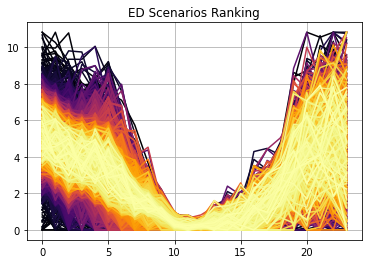

In [92]:
x_ = np.linspace(0, N_hours - 1, N_hours, dtype = int)
z_ = plt.cm.inferno(np.linspace(0, 1., N_scenarios))

plt.figure()
plt.title('ED Scenarios Ranking')
for idx, i in zip(ed_rank_, range(N_scenarios)):
    plt.plot(x_, Y_sc_prime_[:, idx], color = z_[i])
plt.grid()
plt.show()

/Users/Guille/Desktop/STATS/data/SimDat_20180722
(1000,) (1000, 4) (1000, 4)


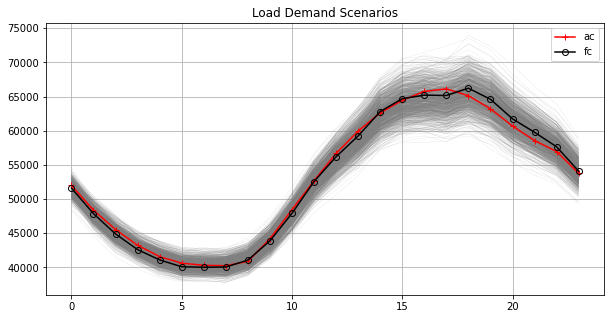

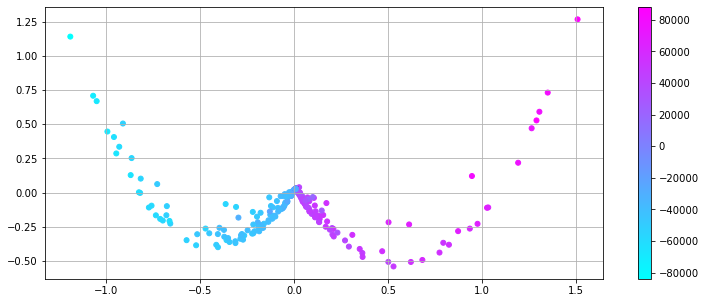

/Users/Guille/Desktop/STATS/data/SimDat_20181126
(1000,) (1000, 4) (1000, 4)


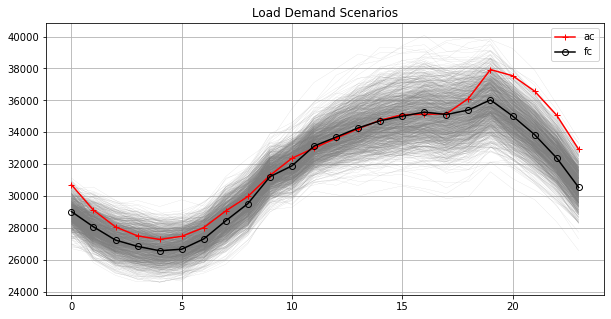

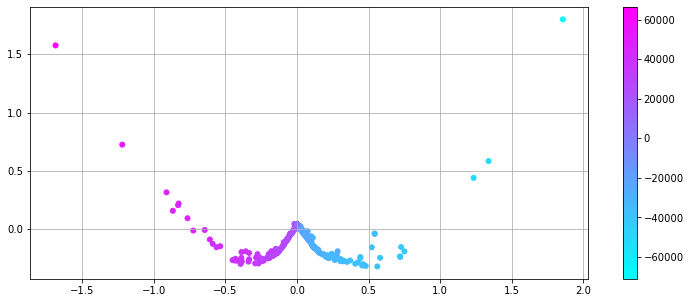

/Users/Guille/Desktop/STATS/data/SimDat_20180613
(1000,) (1000, 4) (1000, 4)


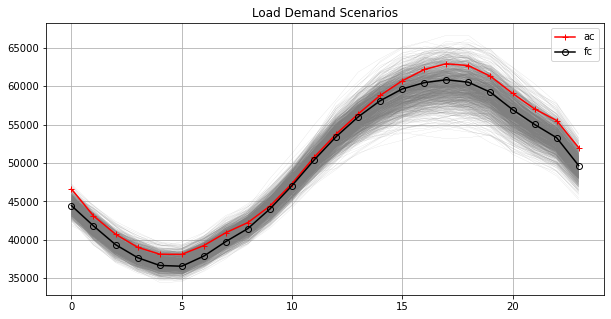

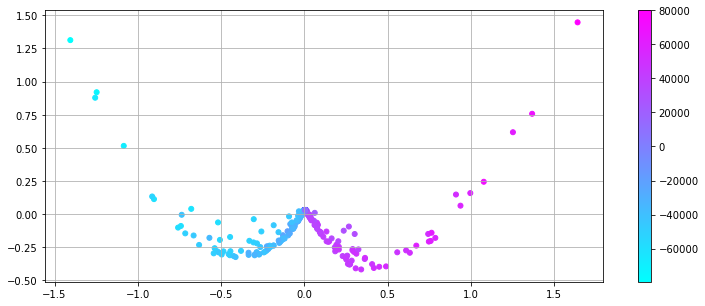

/Users/Guille/Desktop/STATS/data/SimDat_20180702
(1000,) (1000, 4) (1000, 4)


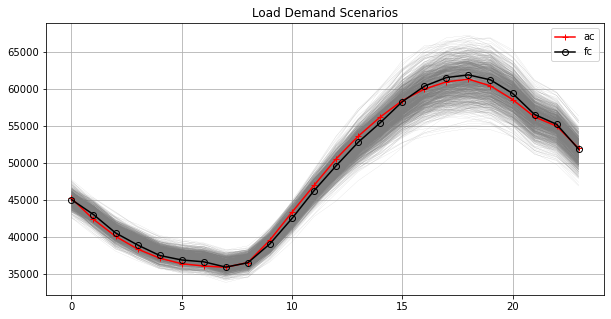

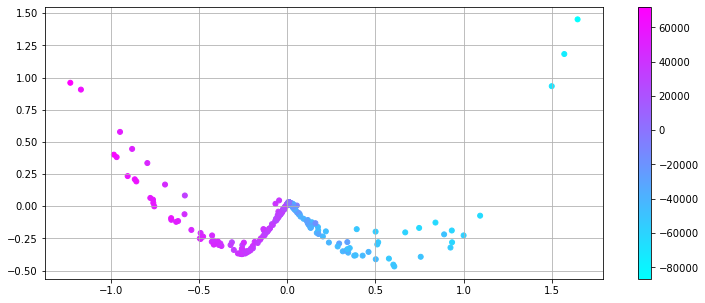

/Users/Guille/Desktop/STATS/data/SimDat_20180718
(1000,) (1000, 4) (1000, 4)


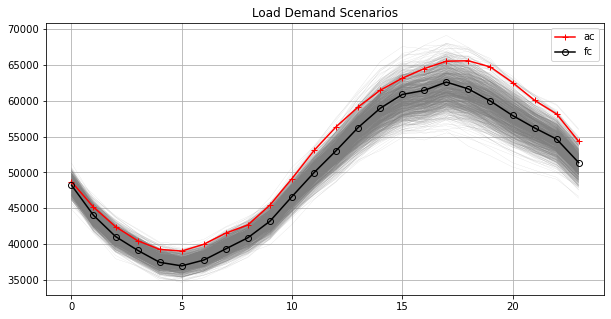

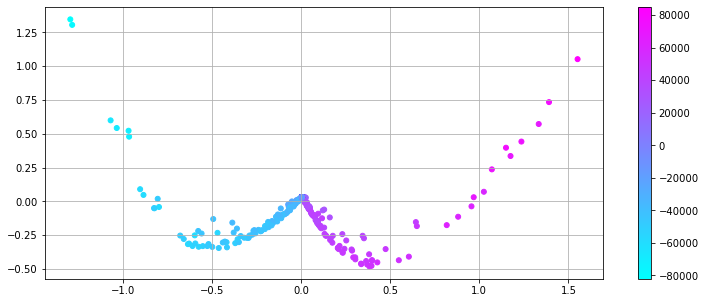

/Users/Guille/Desktop/STATS/data/SimDat_20180911
(1000,) (1000, 4) (1000, 4)


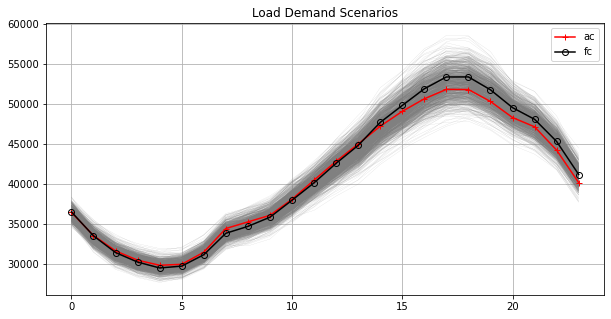

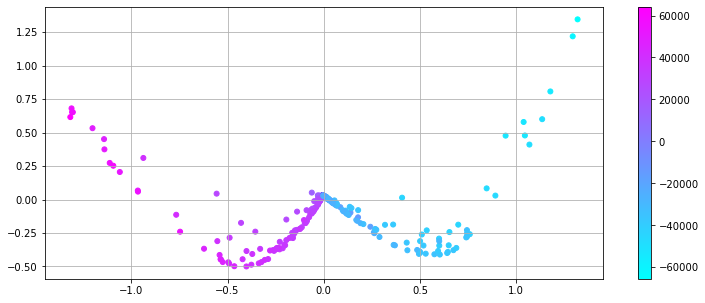

In [47]:
# Compute sample probability assiming multivariate normal distribution
def _multivariate_norma_dist(Y_sc_):
    y_sc_  = np.array(Y_sc_.T, dtype = float)
    mu_    = np.mean(y_sc_, axis = 0)
    Sigma_ = np.cov(y_sc_.T)
    return multivariate_normal(mu_, Sigma_).pdf(y_sc_)

# This is the path to data (stract inside Sim* files)
path_to_data = r'/Users/Guille/Desktop/STATS/data/'

# Loop over day-files in data directory
for file in glob.glob(path_to_data + r'Sim*'):
    print(file)
    
    L_, S_, W_ = _load_all_datasets(file)

    # Aggregate actual from load, solar and wind
    L_ac_total_ = np.sum(L_[0], axis = 1)
    S_ac_total_ = np.sum(S_[0], axis = 1)
    W_ac_total_ = np.sum(W_[0], axis = 1)
    #print(L_ac_total_.shape, S_ac_total_.shape, W_ac_total_.shape)

    # Aggregate forecast from load, solar and wind
    L_fc_total_ = np.sum(L_[1], axis = 1)
    S_fc_total_ = np.sum(S_[1], axis = 1)
    W_fc_total_ = np.sum(W_[1], axis = 1)
    #print(L_fc_total_.shape, S_fc_total_.shape, W_fc_total_.shape)
    
    # Aggregate sceneratios from load, solar and wind
    L_sc_total_ = np.sum(L_[2], axis = 2)
    S_sc_total_ = np.sum(S_[2], axis = 2)
    W_sc_total_ = np.sum(W_[2], axis = 2)
    #print(L_sc_total_.shape, S_sc_total_.shape, W_sc_total_.shape)

    x_24_ = np.arange(0, L_sc_total_.shape[0], 1)
    
    plt.figure(figsize = (10, 5))
    plt.title('Load Demand Scenarios')
    plt.plot(x_24_, L_sc_total_, color = 'gray',  alpha  = 0.75, linewidth = .1)
    plt.plot(x_24_, L_ac_total_, color = 'red',   marker = '+', label = 'ac')
    plt.plot(x_24_, L_fc_total_, color = 'black', marker = 'o', markerfacecolor = 'None', label = 'fc')
    plt.legend()
    plt.grid()
    
    #z_sc_ = _multivariate_norma_dist(L_sc_total_)
    
    m_ = np.mean(L_sc_total_, axis = 1)[:, np.newaxis]
    M_ = np.repeat(m_, L_sc_total_.shape[1], axis = 1)
    e_ = np.sum(L_sc_total_ - M_, axis = 0)
    idx_ = np.argsort(e_)

#     plt.figure(figsize = (10, 5))
#     plt.title(r'Net Load Scenarios Density')
    
#     colors_ = plt.cm.cool(np.linspace(0, 1., L_sc_total_.shape[1]))
    
#     for i in range(1000):    
#         plt.plot(x_24_, L_sc_total_[:, idx_[i]], color = colors_[i], alpha = 1., linewidth = .1)
#     plt.grid()
#     plt.show()
    
    # Data Standardization
    X_ = np.array(L_sc_total_.T, dtype = float)
    X_ = StandardScaler().fit(X_).transform(X_)

    # Kernel Functions
    #K_ = linear_kernel(X_, X_)
    #K_ = polynomial_kernel(X_, X_, degree = 5, gamma = 10.)
    #K_ = rbf_kernel(X_, X_, gamma = 10.)
    #K_ = laplacian_kernel(X_, X_, gamma = 10.)
    K_ = sigmoid_kernel(X_, X_, gamma = .15, coef0 = 10.)

    # PCA in a feature space  
    _KPCA = KernelPCA(n_components          = 4,
                      eigen_solver          = 'dense',
                      kernel                = 'precomputed', 
                      fit_inverse_transform = False).fit(K_)

    # Reduce dimensionality of the feature space
    X_prime_ = _KPCA.transform(K_)
    
    print(e_.shape, colors_.shape, X_prime_.shape)
    
    #for i in range(X_prime_.shape[1] - 2):
    plt.figure(figsize = (12.5, 5))
    plt.scatter(X_prime_[:, 0], X_prime_[:, 1], c = e_, alpha = 1., marker = '.', s = 100., cmap = 'cool')
    plt.colorbar()
    plt.grid()
    plt.show()

#     plt.figure(figsize = (12.5, 5))
#     plt.scatter(X_prime_[:, 0], X_prime_[:, 2], c = e_, alpha = 1., marker = '.', s = 100., cmap = 'cool')
#     plt.colorbar()
#     plt.grid()
#     plt.show()
    
#     plt.figure(figsize = (12.5, 5))
#     plt.scatter(X_prime_[:, 0], X_prime_[:, 3], c = e_, alpha = 1., marker = '.', s = 100., cmap = 'cool')
#     plt.colorbar()
#     plt.grid()
#     plt.show()
    
#     plt.figure()
#     plt.plot(_KPCA.lambdas_)
#     plt.show()

/Users/Guille/Desktop/STATS/data/SimDat_20180722


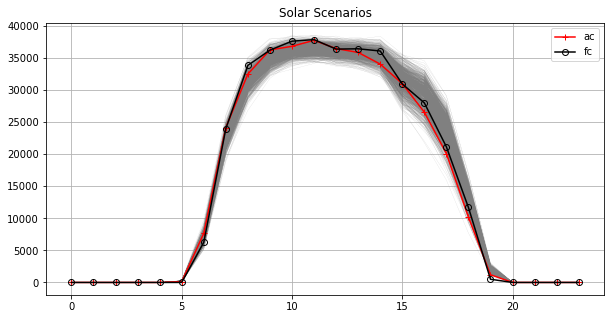

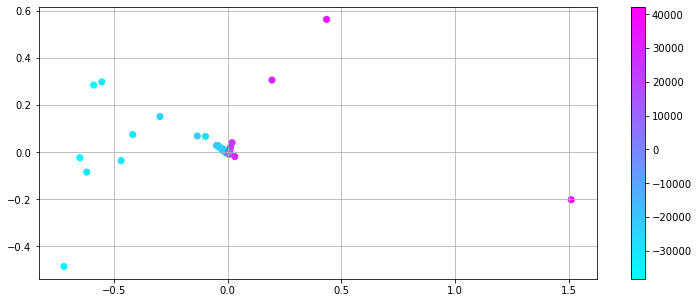

/Users/Guille/Desktop/STATS/data/SimDat_20181126


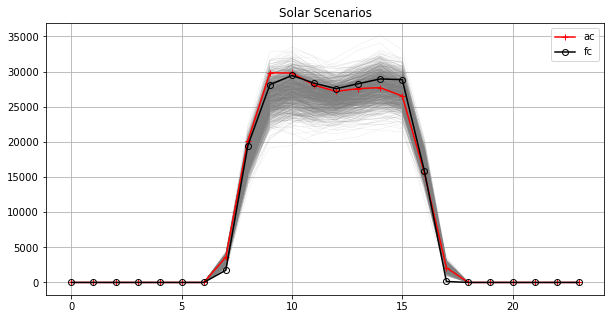

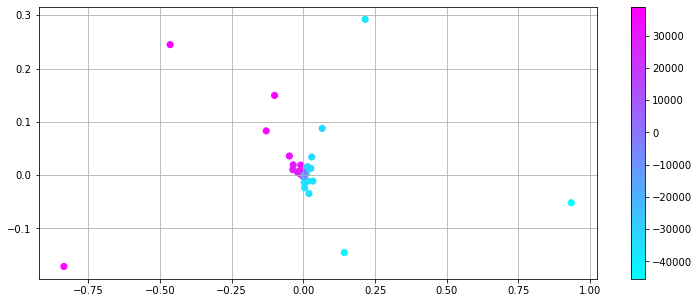

/Users/Guille/Desktop/STATS/data/SimDat_20180613


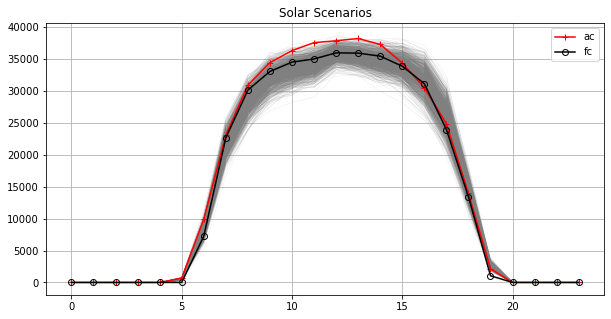

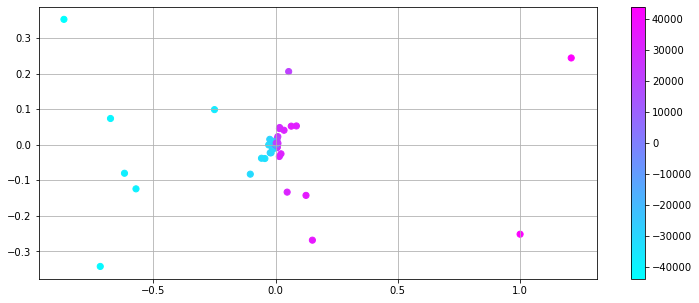

/Users/Guille/Desktop/STATS/data/SimDat_20180702


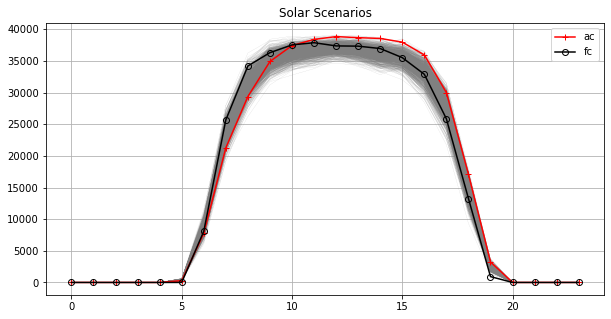

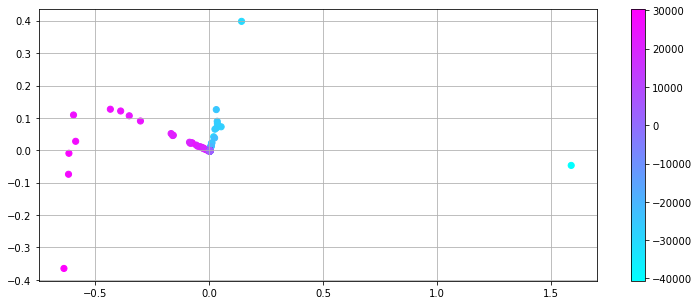

/Users/Guille/Desktop/STATS/data/SimDat_20180718


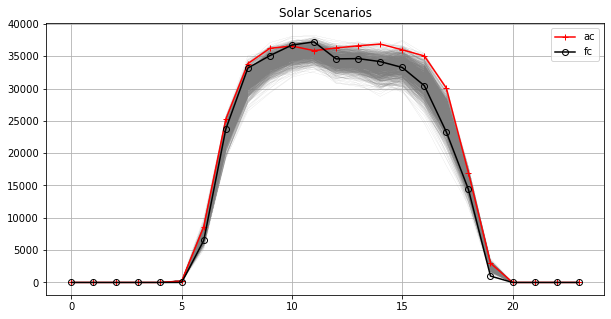

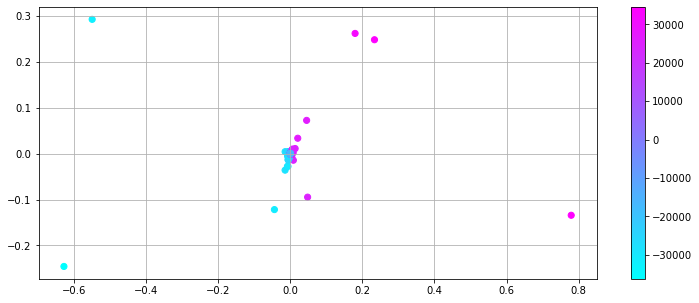

/Users/Guille/Desktop/STATS/data/SimDat_20180911


KeyboardInterrupt: 

In [43]:
# This is the path to data (stract inside Sim* files)
path_to_data = r'/Users/Guille/Desktop/STATS/data/'

# Loop over day-files in data directory
for file in glob.glob(path_to_data + r'Sim*'):
    print(file)
    
    L_, S_, W_ = _load_all_datasets(file)

    # Aggregate actual from load, solar and wind
    L_ac_total_ = np.sum(L_[0], axis = 1)
    S_ac_total_ = np.sum(S_[0], axis = 1)
    W_ac_total_ = np.sum(W_[0], axis = 1)
    #print(L_ac_total_.shape, S_ac_total_.shape, W_ac_total_.shape)

    # Aggregate forecast from load, solar and wind
    L_fc_total_ = np.sum(L_[1], axis = 1)
    S_fc_total_ = np.sum(S_[1], axis = 1)
    W_fc_total_ = np.sum(W_[1], axis = 1)
    #print(L_fc_total_.shape, S_fc_total_.shape, W_fc_total_.shape)
    
    # Aggregate sceneratios from load, solar and wind
    L_sc_total_ = np.sum(L_[2], axis = 2)
    S_sc_total_ = np.sum(S_[2], axis = 2)
    W_sc_total_ = np.sum(W_[2], axis = 2)
    #print(L_sc_total_.shape, S_sc_total_.shape, W_sc_total_.shape)

    x_24_ = np.arange(0, S_sc_total_.shape[0], 1)
    
    plt.figure(figsize = (10, 5))
    plt.title('Solar Scenarios')
    plt.plot(x_24_, S_sc_total_, color = 'gray', alpha = 0.75, linewidth = .1)
    plt.plot(x_24_, S_ac_total_, color = 'red', marker = '+', label = 'ac')
    plt.plot(x_24_, S_fc_total_, color = 'black', marker = 'o', markerfacecolor = 'None', label = 'fc')
    plt.legend()
    plt.grid()
    
    m_ = np.mean(S_sc_total_, axis = 1)[:, np.newaxis]
    M_ = np.repeat(m_, S_sc_total_.shape[1], axis = 1)
    e_ = np.sum(S_sc_total_ - M_, axis = 0)
    idx_ = np.argsort(e_)

    # Data Standardization
    X_ = np.array(S_sc_total_.T, dtype = float)
    X_ = StandardScaler().fit(X_).transform(X_)

    # Kernel Functions
    #K_ = linear_kernel(X_, X_)
    #K_ = polynomial_kernel(X_, X_, degree = 2, gamma = 10.)
    #K_ = rbf_kernel(X_, X_, gamma = 10.)
    #K_ = laplacian_kernel(X_, X_, gamma = 10.)
    K_ = sigmoid_kernel(X_, X_, gamma = .15, coef0 = 10.)

    # PCA in a feature space  
    _KPCA = KernelPCA(n_components          = 2,
                      eigen_solver          = 'dense',
                      kernel                = 'precomputed', 
                      fit_inverse_transform = False).fit(K_)

    # Reduce dimensionality of the feature space
    X_prime_ = _KPCA.transform(K_)
    
#     z_hat_ = np.zeros((X_prime_.shape[0]))
#     idx_   = X_prime_[:, 0] > 0.
#     X0_    = np.zeros(X_prime_.shape)
#     z_hat_[idx_] = np.sqrt(np.sum((X0_[idx_, :] + X_prime_[idx_, :])**2, axis = 1))

    plt.figure(figsize = (12.5, 5))
    plt.scatter(X_prime_[:, 0], X_prime_[:, 1], c = e_, marker = '.', s = 150., cmap = 'cool')
    plt.colorbar()
    plt.grid()
    plt.show()

#     N_selected = 20
#     index_     = np.argsort(z_hat_)[::-1]
#     colors_    = plt.cm.viridis(np.linspace(0, 1., N_selected))

#     plt.figure(figsize = (10, 5))
#     plt.title('Load Selected Scenarios')
#     plt.plot(L_sc_total_, color = 'gray', alpha = .5, linewidth = .5)

#     for i in range(N_selected):
#         plt.plot(L_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)

#     plt.plot(x_24_, L_ac_total_, color = 'red', marker = '+', label = 'ac')
#     plt.legend()
#     plt.show()

#     plt.figure(figsize = (10, 5))
#     plt.title('Solar Selected Scenarios')
#     plt.plot(S_sc_total_, color = 'gray', alpha = .5, linewidth = .5)

#     for i in range(N_selected):
#         plt.plot(S_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)

#     plt.plot(x_24_, S_ac_total_, color = 'red', marker = '+', label = 'ac')
#     plt.legend()
#     plt.show()

#     plt.figure(figsize = (10, 5))
#     plt.title('Wind Selected Scenarios')
#     plt.plot(W_sc_total_, color = 'gray', alpha = .5, linewidth = .5)

#     for i in range(N_selected):
#         plt.plot(W_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)

#     plt.plot(x_24_, W_ac_total_, color = 'red', marker = '+', label = 'ac')
#     plt.legend()
#     plt.show()

In [ ]:
# This is the path to data (stract inside Sim* files)
path_to_data = r'/Users/Guille/Desktop/STATS/data/'

# Loop over day-files in data directory
for file in glob.glob(path_to_data + r'Sim*'):
    print(file)
    
    L_, S_, W_ = _load_all_datasets(file)

    # Aggregate actual from load, solar and wind
    L_ac_total_ = np.sum(L_[0], axis = 1)
    S_ac_total_ = np.sum(S_[0], axis = 1)
    W_ac_total_ = np.sum(W_[0], axis = 1)
    #print(L_ac_total_.shape, S_ac_total_.shape, W_ac_total_.shape)

    # Aggregate forecast from load, solar and wind
    L_fc_total_ = np.sum(L_[1], axis = 1)
    S_fc_total_ = np.sum(S_[1], axis = 1)
    W_fc_total_ = np.sum(W_[1], axis = 1)
    #print(L_fc_total_.shape, S_fc_total_.shape, W_fc_total_.shape)
    
    # Aggregate sceneratios from load, solar and wind
    L_sc_total_ = np.sum(L_[2], axis = 2)
    S_sc_total_ = np.sum(S_[2], axis = 2)
    W_sc_total_ = np.sum(W_[2], axis = 2)
    #print(L_sc_total_.shape, S_sc_total_.shape, W_sc_total_.shape)

    x_24_ = np.arange(0, S_sc_total_.shape[0], 1)
    
    plt.figure(figsize = (10, 5))
    plt.title('Solar Generation Scenarios')
    plt.plot(x_24_, S_sc_total_, color = 'gray', alpha = 0.75, linewidth = .1)
    plt.plot(x_24_, S_ac_total_, color = 'red', marker = '+', label = 'ac')
    plt.plot(x_24_, S_fc_total_, color = 'black', marker = 'o', markerfacecolor = 'None', label = 'fc')
    plt.legend()
    plt.grid()

    # Data Standardization
    X_ = np.array(S_sc_total_.T, dtype = float)
    X_ = StandardScaler().fit(X_).transform(X_)

    # Kernel Functions
    #K_ = linear_kernel(X_, X_)
    #K_ = polynomial_kernel(X_, X_, degree = 2, gamma = 10.)
    #K_ = rbf_kernel(X_, X_, gamma = 10.)
    #K_ = laplacian_kernel(X_, X_, gamma = 10.)
    K_ = sigmoid_kernel(X_, X_, gamma = .15, coef0 = 10.)

    # PCA in a feature space  
    _KPCA = KernelPCA(n_components          = 2,
                      eigen_solver          = 'dense',
                      kernel                = 'precomputed', 
                      fit_inverse_transform = False).fit(K_)

    # Reduce dimensionality of the feature space
    X_prime_ = _KPCA.transform(K_)
        
    z_hat_ = np.zeros((X_prime_.shape[0]))
    idx_   = X_prime_[:, 0] < 0.
    X0_    = np.zeros(X_prime_.shape)
    z_hat_[idx_] = np.sqrt(np.sum((X0_[idx_, :] + X_prime_[idx_, :])**2, axis = 1))

    plt.figure(figsize = (12.5, 5))
    plt.scatter(X_prime_[:, 0], X_prime_[:, 1], c = z_hat_, marker = '.', s = 350.)
    plt.colorbar()
    plt.grid()
    plt.show()
    
    N_selected = 20
    index_     = np.argsort(z_hat_)[::-1]
    colors_    = plt.cm.viridis(np.linspace(0, 1., N_selected))
    
    plt.figure(figsize = (10, 5))
    plt.title('Solar Selected Scenarios')
    plt.plot(S_sc_total_, color = 'gray', alpha = .5, linewidth = .5)
    
    for i in range(N_selected):
        plt.plot(S_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)
        
    plt.plot(x_24_, S_ac_total_, color = 'red', marker = '+', label = 'ac')
    plt.legend()
    plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.title('Load Selected Scenarios')
    plt.plot(L_sc_total_, color = 'gray', alpha = .5, linewidth = .5)
    
    for i in range(N_selected):
        plt.plot(L_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)
        
    plt.plot(x_24_, L_ac_total_, color = 'red', marker = '+', label = 'ac')
    plt.legend()
    plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.title('Wind Selected Scenarios')
    plt.plot(W_sc_total_, color = 'gray', alpha = .5, linewidth = .5)
    
    for i in range(N_selected):
        plt.plot(W_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)
        
    plt.plot(x_24_, W_ac_total_, color = 'red', marker = '+', label = 'ac')
    plt.legend()
    plt.show()

/Users/Guille/Desktop/STATS/data/SimDat_20180722


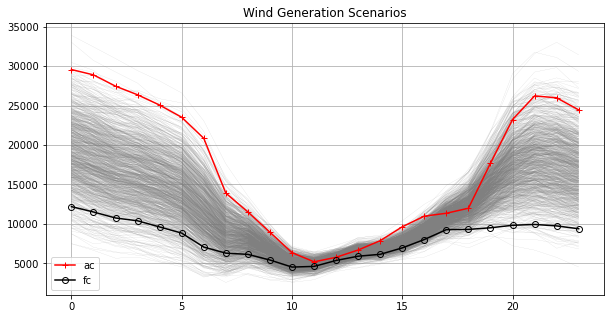

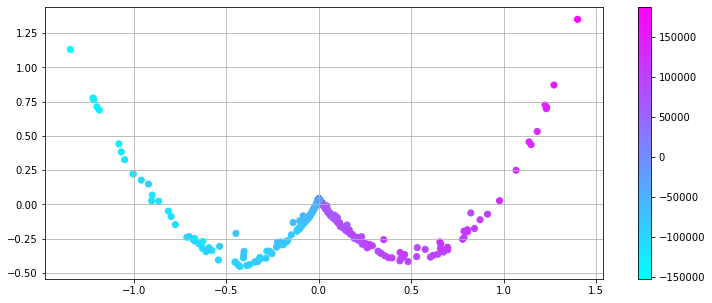

/Users/Guille/Desktop/STATS/data/SimDat_20181126


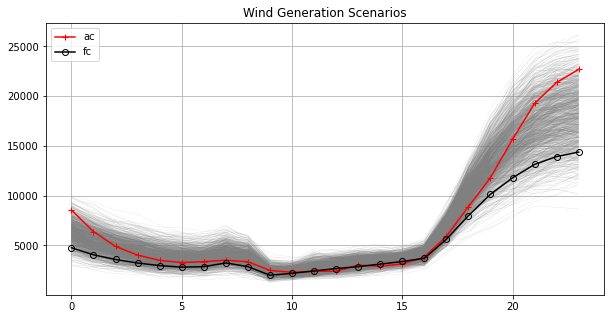

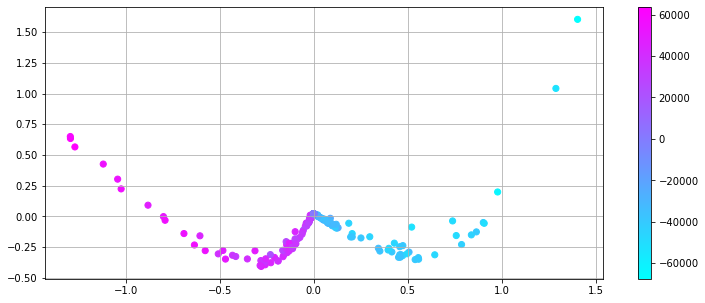

/Users/Guille/Desktop/STATS/data/SimDat_20180613


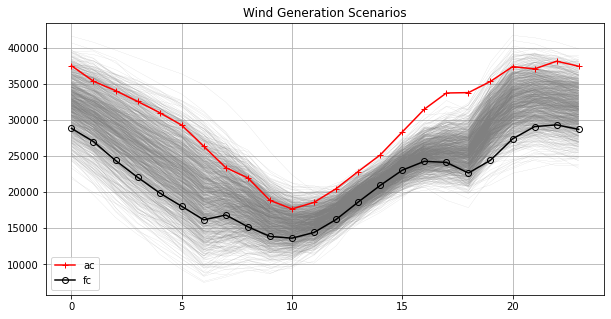

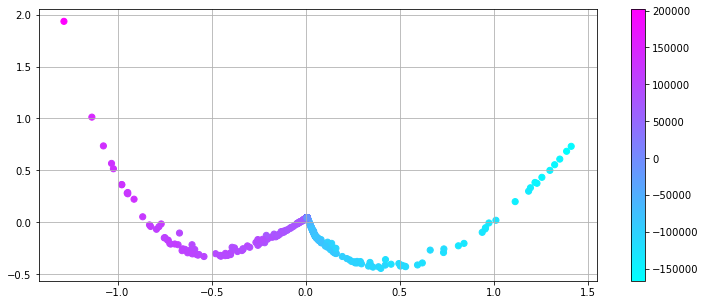

/Users/Guille/Desktop/STATS/data/SimDat_20180702


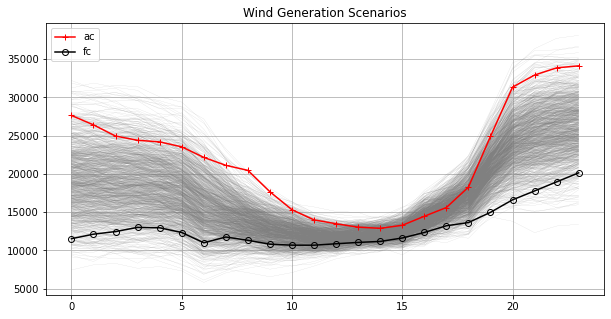

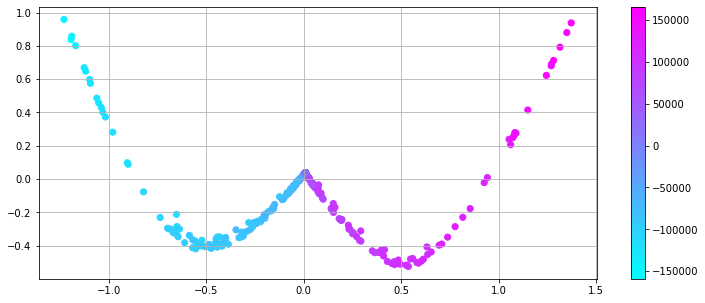

/Users/Guille/Desktop/STATS/data/SimDat_20180718


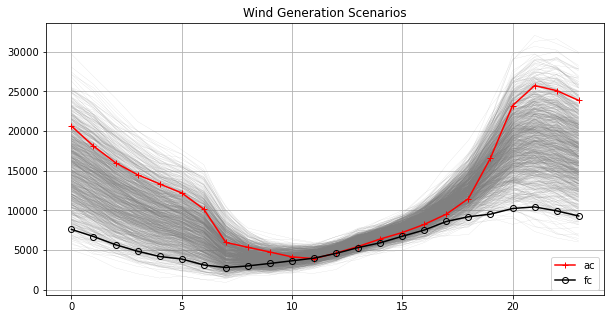

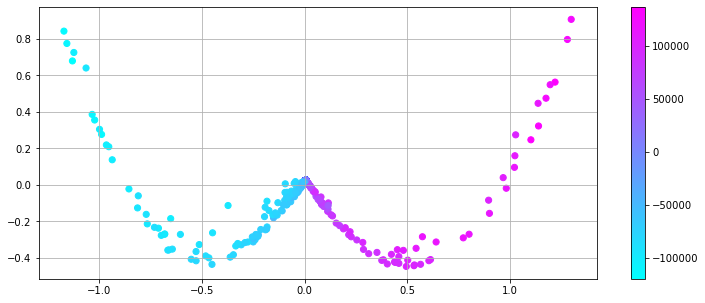

/Users/Guille/Desktop/STATS/data/SimDat_20180911


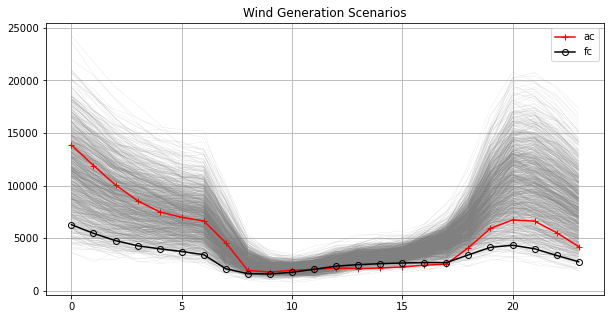

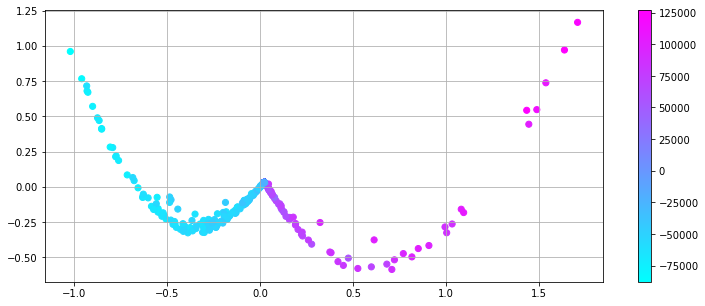

In [45]:
# This is the path to data (stract inside Sim* files)
path_to_data = r'/Users/Guille/Desktop/STATS/data/'

# Loop over day-files in data directory
for file in glob.glob(path_to_data + r'Sim*'):
    print(file)
    
    L_, S_, W_ = _load_all_datasets(file)

    # Aggregate actual from load, solar and wind
    L_ac_total_ = np.sum(L_[0], axis = 1)
    S_ac_total_ = np.sum(S_[0], axis = 1)
    W_ac_total_ = np.sum(W_[0], axis = 1)
    #print(L_ac_total_.shape, S_ac_total_.shape, W_ac_total_.shape)

    # Aggregate forecast from load, solar and wind
    L_fc_total_ = np.sum(L_[1], axis = 1)
    S_fc_total_ = np.sum(S_[1], axis = 1)
    W_fc_total_ = np.sum(W_[1], axis = 1)
    #print(L_fc_total_.shape, S_fc_total_.shape, W_fc_total_.shape)
    
    # Aggregate sceneratios from load, solar and wind
    L_sc_total_ = np.sum(L_[2], axis = 2)
    S_sc_total_ = np.sum(S_[2], axis = 2)
    W_sc_total_ = np.sum(W_[2], axis = 2)
    #print(L_sc_total_.shape, S_sc_total_.shape, W_sc_total_.shape)

    x_24_ = np.arange(0, W_sc_total_.shape[0], 1)
    
    plt.figure(figsize = (10, 5))
    plt.title('Wind Generation Scenarios')
    plt.plot(x_24_, W_sc_total_, color = 'gray', alpha = 0.75, linewidth = .1)
    plt.plot(x_24_, W_ac_total_, color = 'red', marker = '+', label = 'ac')
    plt.plot(x_24_, W_fc_total_, color = 'black', marker = 'o', markerfacecolor = 'None', label = 'fc')
    plt.legend()
    plt.grid()
    
    m_ = np.mean(W_sc_total_, axis = 1)[:, np.newaxis]
    M_ = np.repeat(m_, W_sc_total_.shape[1], axis = 1)
    e_ = np.sum(W_sc_total_ - M_, axis = 0)
    idx_ = np.argsort(e_)

    # Data Standardization
    X_ = np.array(W_sc_total_.T, dtype = float)
    X_ = StandardScaler().fit(X_).transform(X_)

    # Kernel Functions
    #K_ = linear_kernel(X_, X_)
    #K_ = polynomial_kernel(X_, X_, degree = 2, gamma = 10.)
    #K_ = rbf_kernel(X_, X_, gamma = 10.)
    #K_ = laplacian_kernel(X_, X_, gamma = 10.)
    K_ = sigmoid_kernel(X_, X_, gamma = .15, coef0 = 10.)

    # PCA in a feature space  
    _KPCA = KernelPCA(n_components          = 2,
                      eigen_solver          = 'dense',
                      kernel                = 'precomputed', 
                      fit_inverse_transform = False).fit(K_)

    # Reduce dimensionality of the feature space
    X_prime_ = _KPCA.transform(K_)
        
#     z_hat_ = np.zeros((X_prime_.shape[0]))
#     idx_   = X_prime_[:, 0] < 0.
#     X0_    = np.zeros(X_prime_.shape)
#     z_hat_[idx_] = np.sqrt(np.sum((X0_[idx_, :] + X_prime_[idx_, :])**2, axis = 1))

    plt.figure(figsize = (12.5, 5))
    plt.scatter(X_prime_[:, 0], X_prime_[:, 1], c = e_, marker = '.', s = 150., cmap = 'cool')
    plt.colorbar()
    plt.grid()
    plt.show()
    
#     N_selected = 20
#     index_     = np.argsort(z_hat_)[::-1]
#     colors_    = plt.cm.viridis(np.linspace(0, 1., N_selected))
    
#     plt.figure(figsize = (10, 5))
#     plt.title('Wind Selected Scenarios')
#     plt.plot(W_sc_total_, color = 'gray', alpha = .5, linewidth = .5)
    
#     for i in range(N_selected):
#         plt.plot(W_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)
        
#     plt.plot(x_24_, W_ac_total_, color = 'red', marker = '+', label = 'ac')
#     plt.legend()
#     plt.show()
    
#     plt.figure(figsize = (10, 5))
#     plt.title('Load Selected Scenarios')
#     plt.plot(L_sc_total_, color = 'gray', alpha = .5, linewidth = .5)
    
#     for i in range(N_selected):
#         plt.plot(L_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)
        
#     plt.plot(x_24_, L_ac_total_, color = 'red', marker = '+', label = 'ac')
#     plt.legend()
#     plt.show()
    
#     plt.figure(figsize = (10, 5))
#     plt.title('Solar Selected Scenarios')
#     plt.plot(S_sc_total_, color = 'gray', alpha = .5, linewidth = .5)
    
#     for i in range(N_selected):
#         plt.plot(S_sc_total_[:, index_[i]], color = colors_[i], alpha = .5, linewidth = 2.5)
        
#     plt.plot(x_24_, S_ac_total_, color = 'red', marker = '+', label = 'ac')
#     plt.legend()
#     plt.show()